<a href="https://colab.research.google.com/github/msevim24/MachineLearning_DeepLearning_Projects/blob/master/Time_Series_with_Arima%2C_Sarimax_%26_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [632]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Modules

In [633]:
# imports
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import sys, os

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline

import statsmodels as ss

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from scipy.stats.distributions import chi2 
from math import sqrt 

## Importing the Data and Pre-processing 

In [634]:
df_raw = pd.read_csv('/content/df_eda_rmysult2.csv',  index_col=0) # to drop unnamed column when importing data
df_raw.head()

,NORDERID,CUSTOMER_ID,CPOSTCODE,DRECEIEVEDDATE,DRECEIEVEDDATE_YEAR,DRECEIEVEDDATE_MONTH,DRECEIEVEDDATE_DAY,DRECEIEVEDDATE_HOUR,DRECEIEVEDDATE_DAY_NAME,DRECEIEVEDDATE_D,...,ITEMCATEGORY,ORDERITEMQUANTITY,PURCHASEPRICE,POSTALSERVICE,TP_per_Quantity,ST_per_Quantity,UK_CPI,Turkey_CPI,Net_Profit,DayTime
0,100587,C0000045,NG15 6DA,31.03.2020 00:00,2020,3,31,14,tuesday,2,...,Default,1,"6,3",Default,"13,9","13,9",1,"14,6","13,9",AfterNoon
1,101224,C0000046,NG6 8DH,24.04.2020 00:00,2020,4,24,20,friday,5,...,Default,1,"6,3",Default,"13,9","13,9",1,"14,6","13,9",Night
2,106962,C0000047,PH20 1AP,26.10.2020 00:00,2020,10,26,13,monday,1,...,Default,2,"6,3",Royal Mail Tracked 24,"46,75","38,96",1,"14,6","77,92",AfterNoon
3,103074,C0000048,RH11 0AN,18.06.2020 00:00,2020,6,18,19,thursday,4,...,Default,1,"6,3",Default,"15,9","15,9",1,"14,6","15,9",Night
4,100690,C0000049,W13 8RG,5.04.2020 00:00,2020,5,4,13,monday,1,...,Default,1,"6,3",2-5 Business Day,"31,04","31,04",1,"14,6","31,04",AfterNoon


In [635]:
df_raw.columns

Index(['NORDERID', 'CUSTOMER_ID', 'CPOSTCODE', 'DRECEIEVEDDATE',
       'DRECEIEVEDDATE_YEAR', 'DRECEIEVEDDATE_MONTH', 'DRECEIEVEDDATE_DAY',
       'DRECEIEVEDDATE_HOUR', 'DRECEIEVEDDATE_DAY_NAME', 'DRECEIEVEDDATE_D',
       'COUNTRY', 'PROCESSEDDATE', 'SOURCE', 'CURRENCY', 'SUBTOTAL', 'TAX',
       'TOTAL', 'ORDERITEMSKU', 'ORDERITEMTITLE', 'ITEMCATEGORY',
       'ORDERITEMQUANTITY', 'PURCHASEPRICE', 'POSTALSERVICE',
       'TP_per_Quantity', 'ST_per_Quantity', 'UK_CPI', 'Turkey_CPI',
       'Net_Profit', 'DayTime'],
      dtype='object')

In [636]:
df_raw['SUBTOTAL'].sample(10)

51317     31,8
83638    16,66
28171    24,99
14011    37,42
36565    11,66
62594    41,58
21479    20,79
8203     27,04
57793    16,58
33900    11,66
Name: SUBTOTAL, dtype: object

In [637]:
# Let's create a data frame with date and sales columns.
df= df_raw[['DRECEIEVEDDATE', 'SUBTOTAL']]

In [638]:
df.head()

,DRECEIEVEDDATE,SUBTOTAL
0,31.03.2020 00:00,"13,9"
1,24.04.2020 00:00,"13,9"
2,26.10.2020 00:00,"77,92"
3,18.06.2020 00:00,"15,9"
4,5.04.2020 00:00,"31,04"


In [639]:
df.shape

(92249, 2)

In [640]:
df.dtypes 

DRECEIEVEDDATE    object
SUBTOTAL          object
dtype: object

DRECEIEVEDDATE must be converted into datetime and SUBTOTAL into float

In [641]:
df['DRECEIEVEDDATE'] = df['DRECEIEVEDDATE'].astype('datetime64')
df['SUBTOTAL'] = df['SUBTOTAL'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [642]:
df.dtypes

DRECEIEVEDDATE    datetime64[ns]
SUBTOTAL                 float64
dtype: object

In [643]:
variables = ['DRECEIEVEDDATE', 'SUBTOTAL']
group_variables = variables[0]
outcome_variable = variables[1]
base = df.groupby(group_variables)[outcome_variable].sum().reset_index()

In [644]:
# Now we can set date column as index
base.set_index('DRECEIEVEDDATE', inplace=True)

In [645]:
base.head()

,SUBTOTAL
DRECEIEVEDDATE,
2019-11-12,319.4
2019-12-12,99.8
2019-12-13,655.1
2019-12-14,969.0
2019-12-15,284.5


In [646]:
# To check whether we have unique index or not, we can use...
df.index.is_unique  # gives boolean value
# or we can use...df.index.duplicated()

True

Our original df includes all values whereas new base data frame has just unique values with sum sales.

It is important to have unique index and sum values in target variable, otherwise we will have an error saying that there are some duplicate indexes. See the differences between them by checking their indexes. In the new situation, the unique and normal index numbers are 1087.

In [647]:
# there is no date index in df.
print(df.index)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            94685, 94686, 94687, 94688, 94689, 94690, 94691, 94692, 94693,
            94694],
           dtype='int64', length=92249)


In [648]:
# On the other hand, base has a date index.
print(base.index)

DatetimeIndex(['2019-11-12', '2019-12-12', '2019-12-13', '2019-12-14',
               '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20',
               ...
               '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05',
               '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09',
               '2022-12-10', '2022-12-11'],
              dtype='datetime64[ns]', name='DRECEIEVEDDATE', length=1087, freq=None)


In [649]:
print(base.index.unique())

DatetimeIndex(['2019-11-12', '2019-12-12', '2019-12-13', '2019-12-14',
               '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20',
               ...
               '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05',
               '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09',
               '2022-12-10', '2022-12-11'],
              dtype='datetime64[ns]', name='DRECEIEVEDDATE', length=1087, freq=None)


#### Generating a complete Index and Setting Frequency

Since we are using daily data, we would like to set a daily frequency. We see our data has a length of 1087 days. By subtracting the smallest date from the largest date, we can tell there are some days missing:

In [650]:
print('\nUnique dates in our data: ', len(base.index.unique()), 'Days')
date_range = base.index.max() - base.index.min()

# Calculate number of days in date range
print('Total days in our date range:', date_range.days, 'Days')
#date_range = pd.date_range(min(df.index), max(df.index))


Unique dates in our data:  1087 Days
Total days in our date range: 1125 Days


We can generate a complete index using Pandas' __[date_range](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html)__ function:

In [651]:
new_index = pd.date_range(base.index.min(), base.index.max())
print(new_index)

DatetimeIndex(['2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
               '2019-11-16', '2019-11-17', '2019-11-18', '2019-11-19',
               '2019-11-20', '2019-11-21',
               ...
               '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05',
               '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09',
               '2022-12-10', '2022-12-11'],
              dtype='datetime64[ns]', length=1126, freq='D')


To use this index, we need to tell Pandas how to treat missing values. In this case, we want to use zero for days without sales data. 

In [652]:
base_new = base.reindex(new_index, fill_value=0)

In [653]:
base_new.index

DatetimeIndex(['2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
               '2019-11-16', '2019-11-17', '2019-11-18', '2019-11-19',
               '2019-11-20', '2019-11-21',
               ...
               '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05',
               '2022-12-06', '2022-12-07', '2022-12-08', '2022-12-09',
               '2022-12-10', '2022-12-11'],
              dtype='datetime64[ns]', length=1126, freq='D')

Resampling: If we want to apply upsampling (Moving to a longer period, like W, M, Q or Y) or downsampling (moving a shorter period, like from year to month) we can apply it in this step. So we can find weekly, monthly, quarterly or annual sales. 

Another way to do is to use sfreq('D') methot.


In [654]:
# Upsampling

In [655]:
sales_weekly = base_new.resample('W').sum()
print('Weekly Sales')
print(sales_weekly.head(), '\n')

sales_monthly = base_new.resample('M').sum()
print('Monthly Sales')
print(sales_monthly.head(), '\n')

sales_quarterly = base_new.resample('Q').sum()
print('Quarterly Sales')
print(sales_quarterly.head(), '\n')

sales_annual = base_new.resample('Y').sum()
print('Annual Sales')
print(sales_annual.head())

Weekly Sales
            SUBTOTAL
2019-11-17     319.4
2019-11-24       0.0
2019-12-01       0.0
2019-12-08       0.0
2019-12-15   2,008.4 

Monthly Sales
            SUBTOTAL
2019-11-30     319.4
2019-12-31   5,961.9
2020-01-31  18,036.8
2020-02-29  17,722.0
2020-03-31  20,763.2 

Quarterly Sales
            SUBTOTAL
2019-12-31   6,281.3
2020-03-31  56,522.0
2020-06-30 118,711.9
2020-09-30 107,508.7
2020-12-31 158,288.9 

Annual Sales
              SUBTOTAL
2019-12-31     6,281.3
2020-12-31   441,031.5
2021-12-31 1,110,287.2
2022-12-31 2,589,019.5


## Variable Transformations
For Time Series models, we may want to use transformed variables (log, difference, growth rate, etc).

### Stationarity Transformations
Concerns about Stationarity often lead to considering variable transformations. Some commonly-used transformation methods (Variable Differencing, Percentage Change, and Log) are implemented below. Because Index has several levels here, these transformations can be done for each outcome variable with one line (the results could be joined together using the Pandas __[concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html)__ method). 

In [656]:
# Variable First Difference
print('Monthly Sales, First Difference \n', sales_monthly.diff().head())

# Variable Percent Change
print('\nMonthly Sales % Change \n', sales_monthly.pct_change().head())

# Log Sales
print('\nlog(1+Monthly Sales) \n', np.log(1 +  sales_monthly).head())

# Add % change to original data:
sales_monthly.join(sales_monthly.pct_change().add_suffix('_%_Change')).head()

Monthly Sales, First Difference 
             SUBTOTAL
2019-11-30       NaN
2019-12-31   5,642.5
2020-01-31  12,074.9
2020-02-29    -314.8
2020-03-31   3,041.3

Monthly Sales % Change 
             SUBTOTAL
2019-11-30       NaN
2019-12-31      17.7
2020-01-31       2.0
2020-02-29      -0.0
2020-03-31       0.2

log(1+Monthly Sales) 
             SUBTOTAL
2019-11-30       5.8
2019-12-31       8.7
2020-01-31       9.8
2020-02-29       9.8
2020-03-31       9.9


,SUBTOTAL,SUBTOTAL_%_Change
2019-11-30,319.4,NaN
2019-12-31,"5,961.9",17.7
2020-01-31,"18,036.8",2.0
2020-02-29,"17,722.0",-0.0
2020-03-31,"20,763.2",0.2


### Rolling Averages and Windows
Another approach to transforming data involves looking at rolling averages. Here we set up rolling calculations for Mean and Standard Deviation, with variable window size. We will plot these a bit later.

In [657]:
window_size = 7
rolling_window = base_new.rolling(window_size)
print('Rolling Mean')
print(rolling_window.mean().dropna().head())
print('\nRolling St. Dev')
print(rolling_window.std().dropna().head())
print('\nCumulative Sales')
print(base_new.cumsum().dropna().head())

Rolling Mean
            SUBTOTAL
2019-11-18      45.6
2019-11-19       0.0
2019-11-20       0.0
2019-11-21       0.0
2019-11-22       0.0

Rolling St. Dev
            SUBTOTAL
2019-11-18     120.7
2019-11-19       0.0
2019-11-20       0.0
2019-11-21       0.0
2019-11-22       0.0

Cumulative Sales
            SUBTOTAL
2019-11-12     319.4
2019-11-13     319.4
2019-11-14     319.4
2019-11-15     319.4
2019-11-16     319.4


# Visualization
Here we explore methods for plotting Time Series Data. Most of these packages use __Matplotlib's [pyplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html)__ library, although it may not be called directly. This means it is possible to adjust plot features, like the title, using __pyplot__ commands.

## Pandas Built-in Plotting
Pandas DataFrames have a built-in __[plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)__ method which, by default, plots columns against the index:

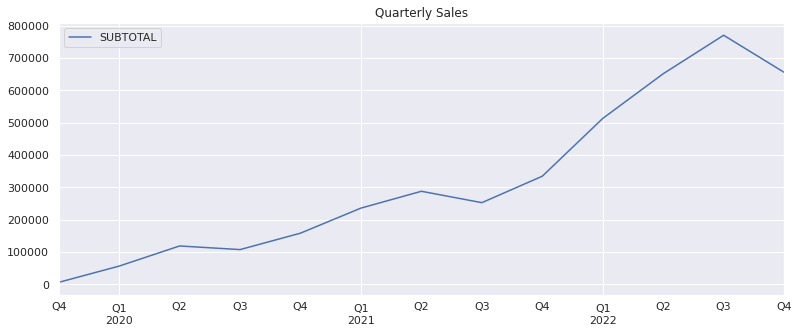

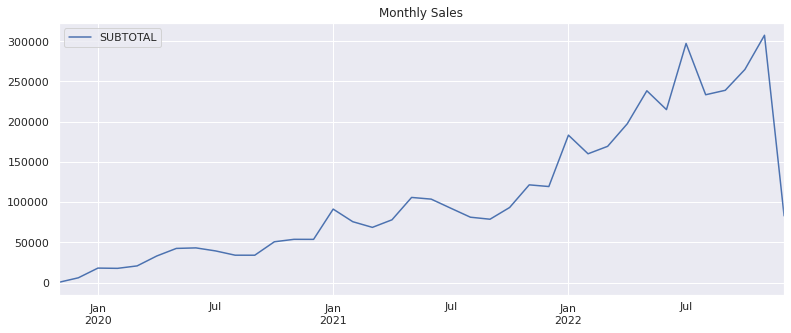

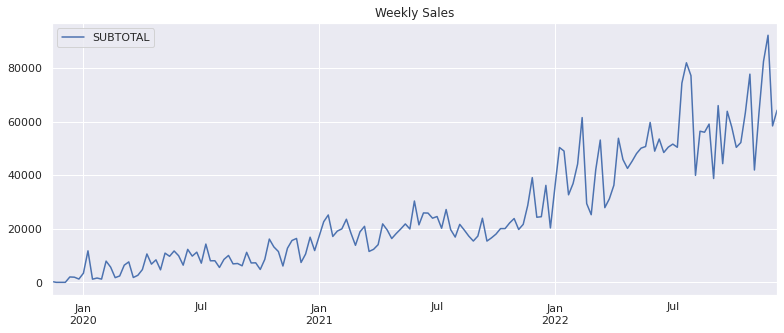

In [658]:
plotsize = (13, 5)
sales_quarterly.plot(figsize=plotsize, title='Quarterly Sales')
#plt.title('Monthly Sales')
sales_monthly.plot(figsize=plotsize, title='Monthly Sales')
#plt.title('Monthly Sales')
sales_weekly.plot(figsize=plotsize, title='Weekly Sales')
#plt.title('Monthly Sales')

Here, we plot functions like rolling averages and cumulative Sales calculated above:

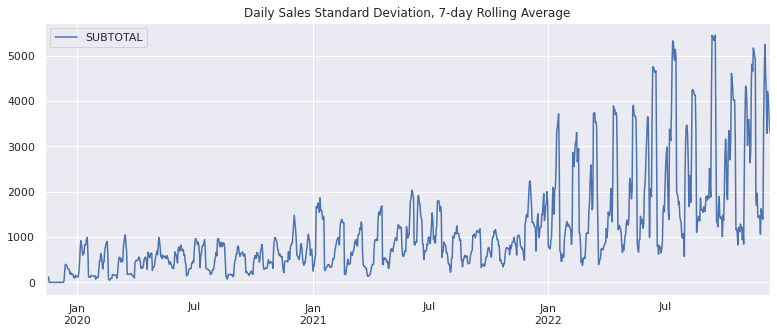

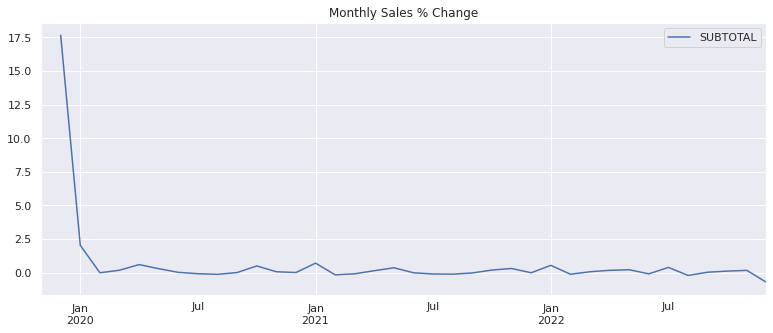

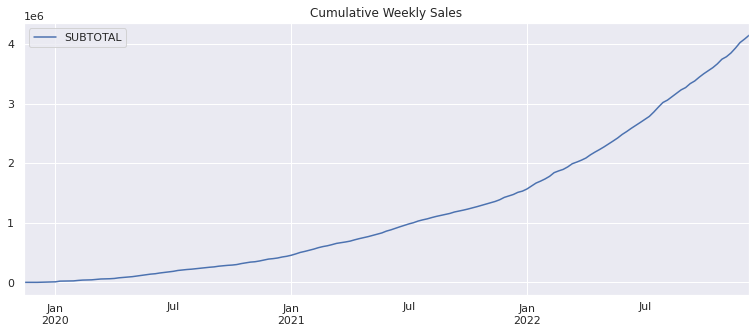

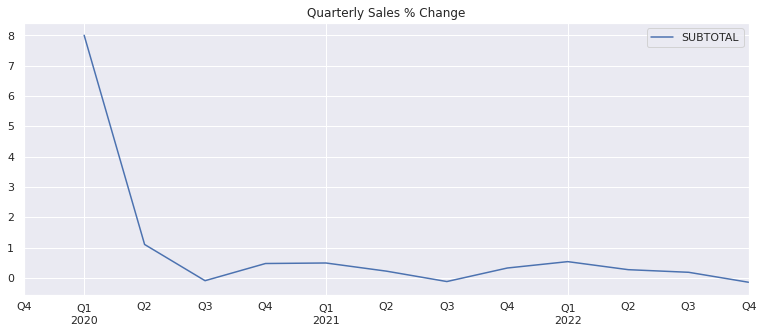

In [659]:
#rolling_window.mean().plot(figsize=plotsize, title='Daily Sales, 7-day Rolling Average')
rolling_window.std().plot(figsize=plotsize, title='Daily Sales Standard Deviation, 7-day Rolling Average')

# Monthly Sales Percent Change
sales_monthly.pct_change().plot(figsize=plotsize, title='Monthly Sales % Change')

# Cumulative Weekly Sales
sales_weekly.cumsum().plot(figsize=plotsize, title='Cumulative Weekly Sales')

# Quarterly Sales Growth
sales_quarterly.pct_change().plot(figsize=plotsize, title='Quarterly Sales % Change')

## Time Series Visualizations
There are a number of packages to help analyze Time Series data and create relevant plots. One example is __[statsmodels](https://www.statsmodels.org/stable/graphics.html#time-series-plots)__, which includes a number of methods for plotting Time Series-specific visualizations:
- __[plot_acf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html#statsmodels.graphics.tsaplots.plot_acf)__: Plot of the Autocorrelation Function
- __[plot_pacf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html#statsmodels.graphics.tsaplots.plot_pacf)__: Plot of the Partial Autocorrelation Function
- __[month_plot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.month_plot.html#statsmodels.graphics.tsaplots.month_plot)__: Seasonal Plot for Monthly Data
- __[quarter_plot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.quarter_plot.html#statsmodels.graphics.tsaplots.quarter_plot)__: Seasonal Plot for Quarterly Data

Daily data Autocorrelation Plots


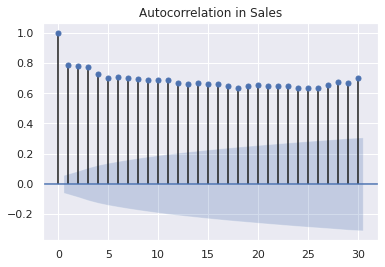

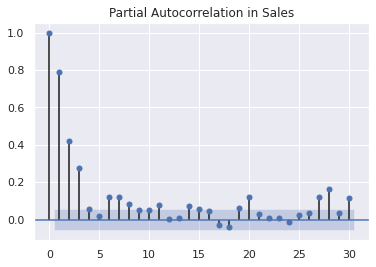

In [660]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

print('Daily data Autocorrelation Plots')
# Autocorrelation and Partial Autocorrelation Functions for Daily Data
acf_plot = plot_acf(base_new['SUBTOTAL'], lags=30, title='Autocorrelation in Sales')
pacf_plot = plot_pacf(base_new['SUBTOTAL'], lags=30, title='Partial Autocorrelation in Sales')


Monthly Data Seasonal Plot


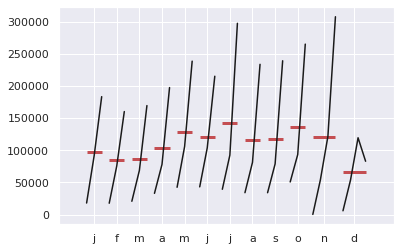

In [661]:
print('\nMonthly Data Seasonal Plot')
m_plot = month_plot(sales_monthly['SUBTOTAL'])


Quarterly Data Seasonal Plot


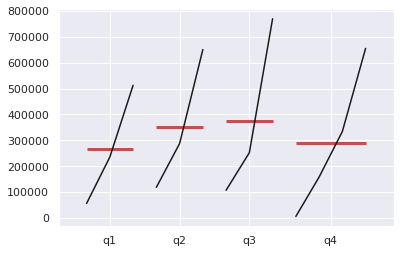

In [662]:
print('\nQuarterly Data Seasonal Plot')
q_plot = quarter_plot(sales_quarterly['SUBTOTAL'])

#### Using the source data, set up monthly data for Sales and Profit by 'SOURCE' by resampling.

In [663]:
df_raw.dtypes

NORDERID                    int64
CUSTOMER_ID                object
CPOSTCODE                  object
DRECEIEVEDDATE             object
DRECEIEVEDDATE_YEAR         int64
DRECEIEVEDDATE_MONTH        int64
DRECEIEVEDDATE_DAY          int64
DRECEIEVEDDATE_HOUR         int64
DRECEIEVEDDATE_DAY_NAME    object
DRECEIEVEDDATE_D            int64
COUNTRY                    object
PROCESSEDDATE              object
SOURCE                     object
CURRENCY                   object
SUBTOTAL                   object
TAX                        object
TOTAL                      object
ORDERITEMSKU               object
ORDERITEMTITLE             object
ITEMCATEGORY               object
ORDERITEMQUANTITY           int64
PURCHASEPRICE              object
POSTALSERVICE              object
TP_per_Quantity            object
ST_per_Quantity            object
UK_CPI                     object
Turkey_CPI                 object
Net_Profit                 object
DayTime                    object
dtype: object

In [664]:
# First change dtypes.
df_raw['DRECEIEVEDDATE'] = df_raw['DRECEIEVEDDATE'].astype('datetime64')
df_raw['SUBTOTAL'] = df_raw['SUBTOTAL'].apply(lambda x: float(x.split()[0].replace(',', '.')))
df_raw['Net_Profit'] = df_raw['Net_Profit'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [665]:
new_vars = ['SOURCE','DRECEIEVEDDATE','SUBTOTAL', 'Net_Profit']
new_base = df_raw[new_vars].set_index('DRECEIEVEDDATE')
prof_pivot = new_base.pivot_table(columns='SOURCE',index = 'DRECEIEVEDDATE')
prof_month = prof_pivot.resample('M').sum()
prof_month.head(10)

Net_Profit                                         \
SOURCE             AMAZON AMAZON FBA DIRECT  EBAY ETSY OnBuy.com   
DRECEIEVEDDATE                                                     
2019-11-30           52.4        0.0    0.0  39.8  0.0       0.0   
2019-12-31          982.3        0.0    0.0 476.0  0.0       0.0   
2020-01-31          990.3        0.0    0.0 798.5  0.0       0.0   
2020-02-29          868.0        0.0    0.0 887.6  0.0       0.0   
2020-03-31          886.6        0.0    0.0 789.8  0.0       0.0   
2020-04-30        1,018.4       26.5    0.0 838.5  0.0       0.0   
2020-05-31        1,098.1        0.0    0.0 864.1  0.0       0.0   
2020-06-30        1,155.0        0.0    0.0 841.6  0.0       0.0   
2020-07-31          900.1        0.0    0.0 848.1  0.0       0.0   
2020-08-31        1,008.3        0.0    0.0 844.8  0.0       0.0   

                                          SUBTOTAL                            \
SOURCE         WAYFAIRCHANNEL WOOCOMMERCE   AMAZON AMAZON FBA DIRECT    EBAY   
DRECEIEVEDDATE                                                                 
2019-11-30                0.0         0.0     52.4        0.0    0.0    54.9   
2019-12-31                0.0         0.0  1,164.4        0.0    0.0   867.2   
2020-01-31                0.0       227.5  1,360.2        0.0    0.0 1,084.7   
2020-02-29                0.0       382.3  1,171.2        0.0    0.0 1,190.2   
2020-03-31                0.0       502.2  1,183.3        0.0    0.0 1,114.6   
2020-04-30                0.0       568.3  1,392.7       26.5    0.0 1,118.9   
2020-05-31                0.0       809.2  1,413.7        0.0    0.0 1,108.3   
2020-06-30                0.0     1,063.8  1,429.2        0.0    0.0 1,141.9   
2020-07-31                0.0     1,253.9  1,336.4        0.0    0.0 1,212.8   
2020-08-31                0.0     1,114.6  1,300.0        0.0    0.0 1,189.1   

                                                          
SOURCE         ETSY OnBuy.com WAYFAIRCHANNEL WOOCOMMERCE  
DRECEIEVEDDATE                                            
2019-11-30      0.0       0.0            0.0         0.0  
2019-12-31      0.0       0.0            0.0         0.0  
2020-01-31      0.0       0.0            0.0       446.7  
2020-02-29      0.0       0.0            0.0       567.1  
2020-03-31      0.0       0.0            0.0     1,026.0  
2020-04-30      0.0       0.0            0.0     1,199.9  
2020-05-31      0.0       0.0            0.0     1,393.7  
2020-06-30      0.0       0.0            0.0     1,428.5  
2020-07-31      0.0       0.0            0.0     2,174.2  
2020-08-31      0.0       0.0            0.0     1,773.3

#### Analyze the results from the first exercise to determine whether Autocorrelation or Seasonal patterns differ by SOURCE or whether we are looking at Sales or Profits.

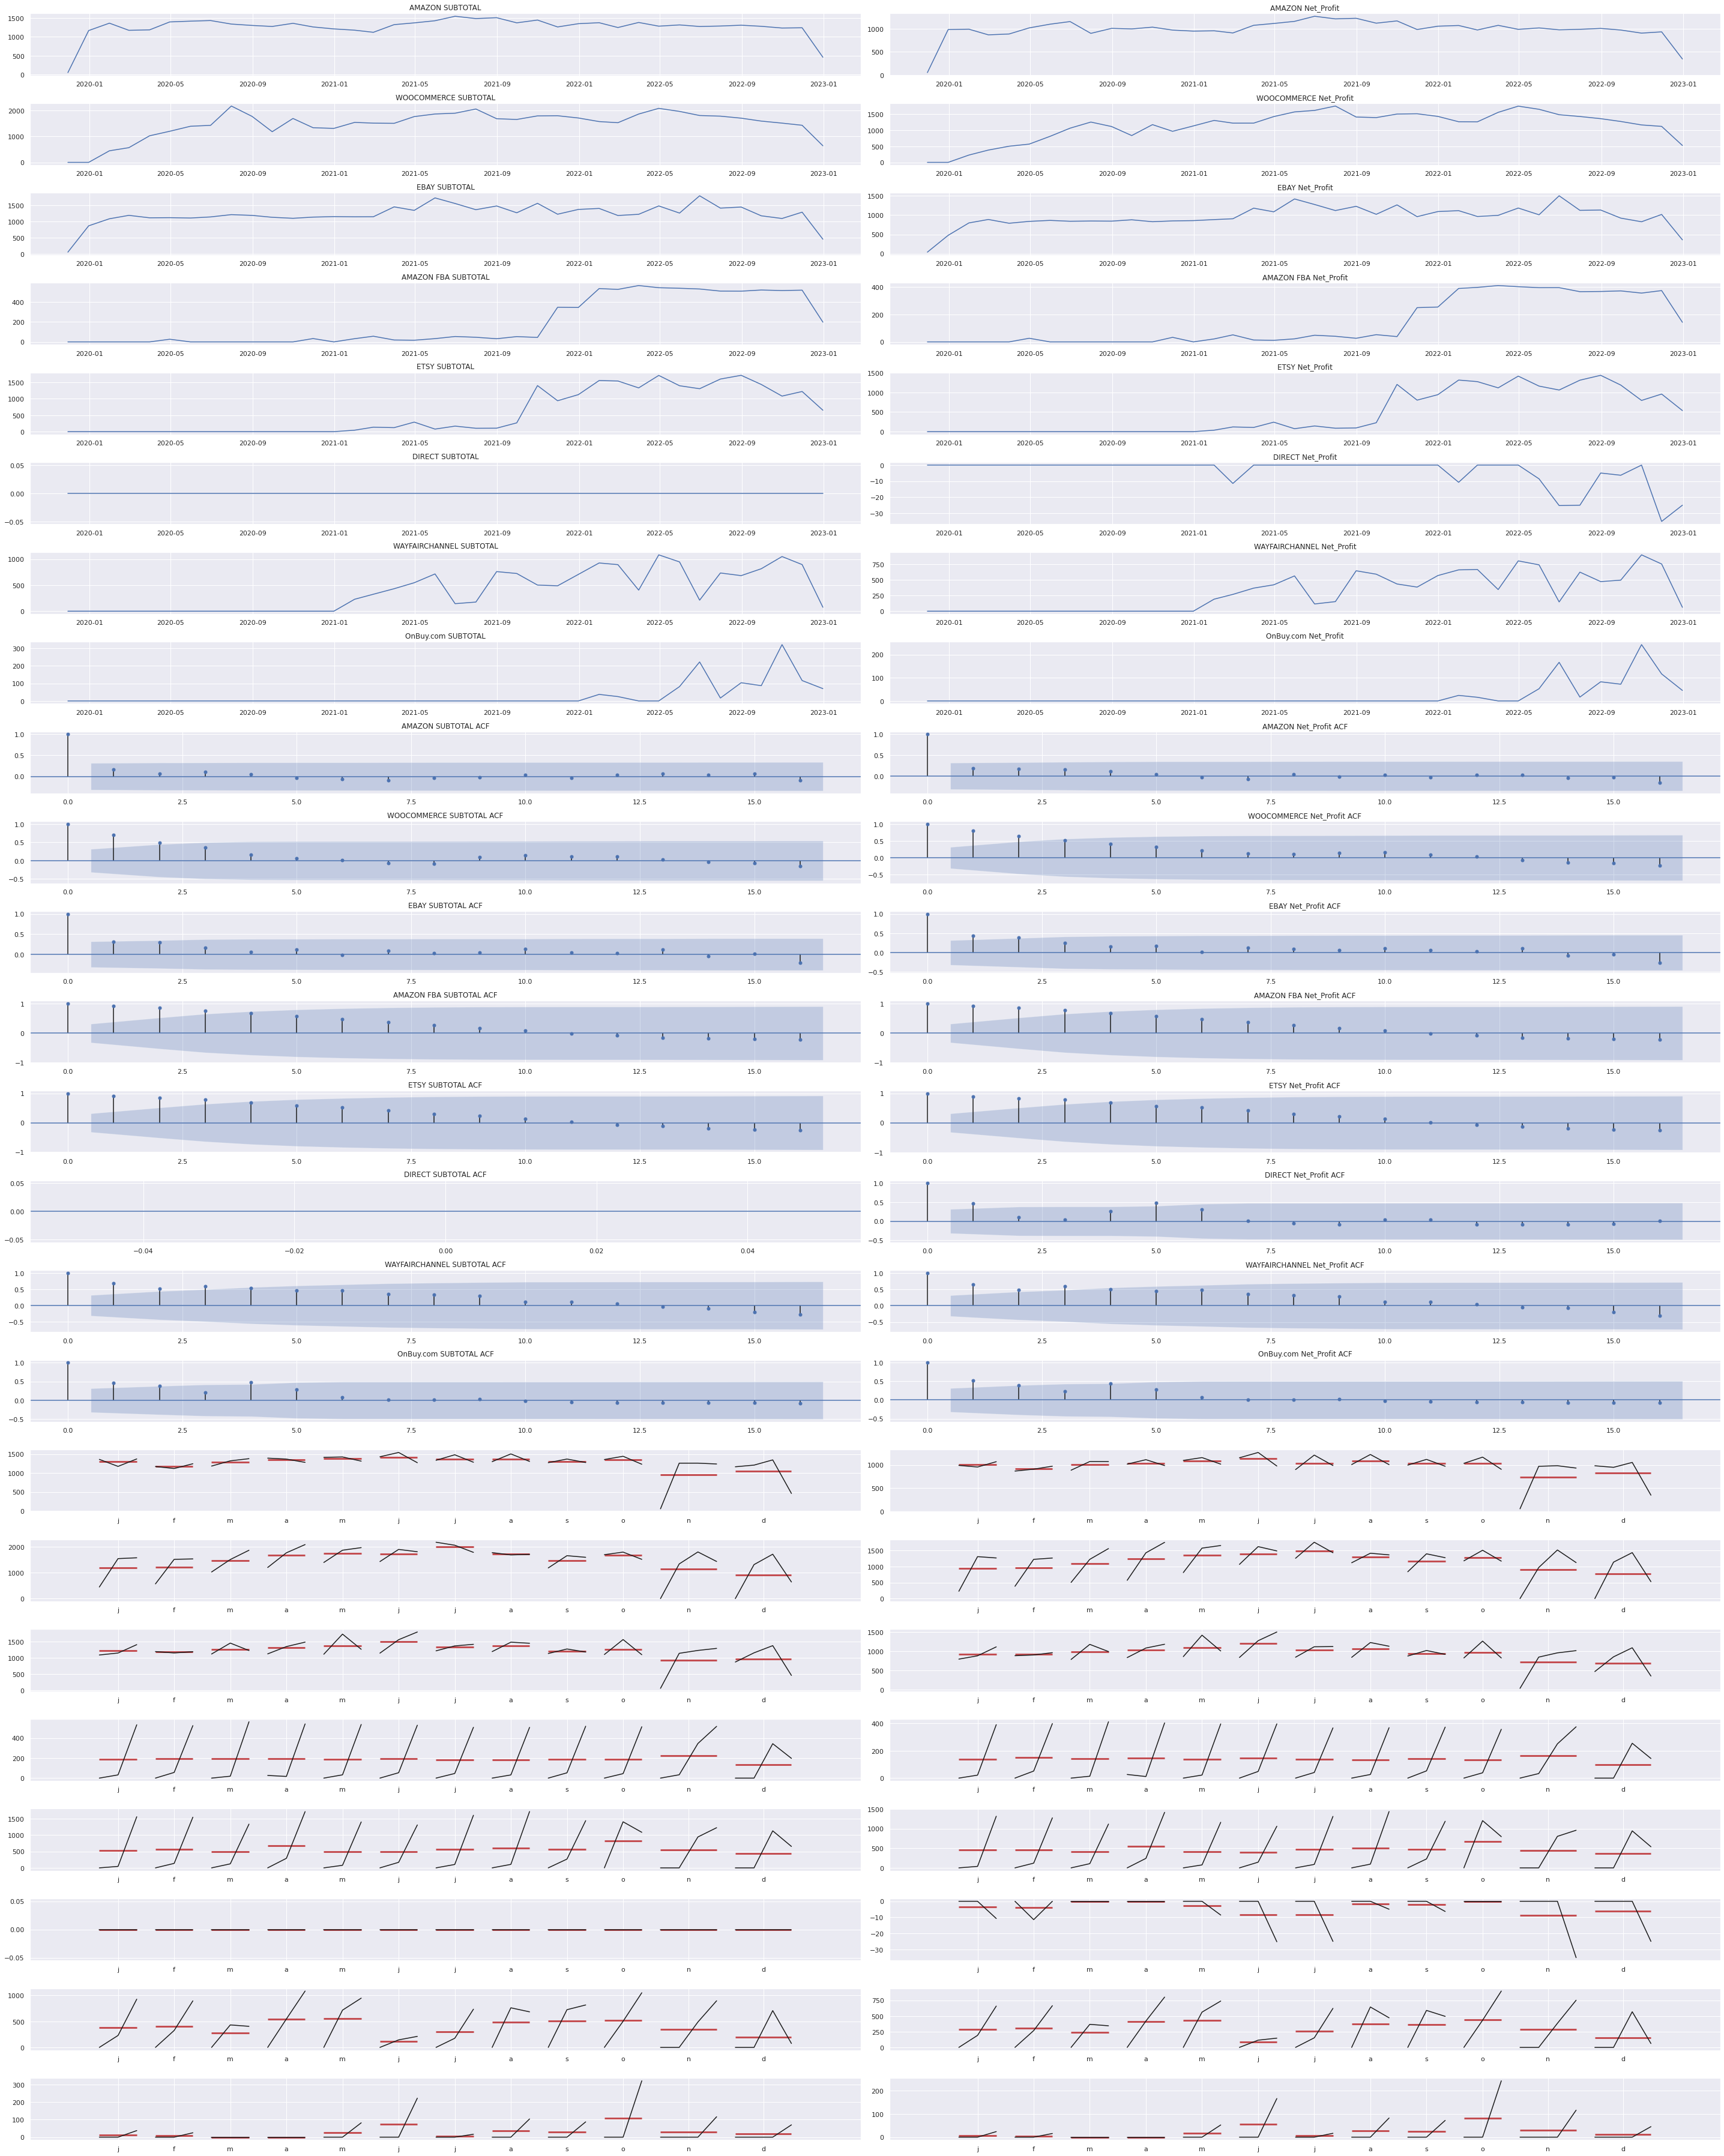

In [666]:
fig,axes = plt.subplots(24,2,figsize=(40,50),)
for i,cat in enumerate(['AMAZON','WOOCOMMERCE','EBAY','AMAZON FBA','ETSY','DIRECT','WAYFAIRCHANNEL','OnBuy.com']):
    for j,money in enumerate(['SUBTOTAL','Net_Profit']):
        axes[i,j].plot(prof_month[money,cat])
        axes[i,j].title.set_text(cat+" "+money)
        plot_acf(prof_month[money,cat],ax=axes[i+8,j],title = cat+" "+money+" ACF")
        month_plot(prof_month[money,cat],ax=axes[i+16,j])

fig.tight_layout()
plt.show()

### ETS Dicomposition 
ETS Decomposition is used to separate different components of a time series. The term ETS stands for Error, Trend, and Seasonality.

There are several ways to plot it.

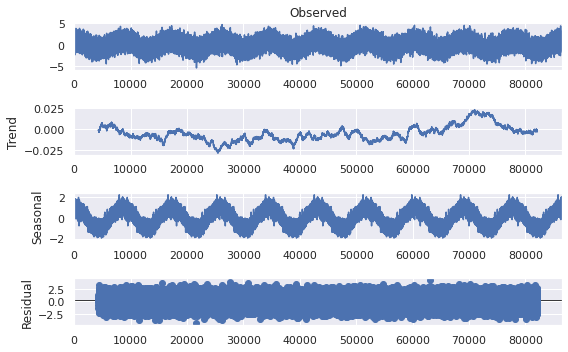

In [667]:
result_additive = seasonal_decompose(sales_monthly, model ='additive')
# I wrote monthly sales because we have to specify a period(like month) to have these graphs

# figsize argument does not work hear to adjust the graph.
PERIOD = 48*180
g = np.random.default_rng(20211225)
y = np.cos(2 * np.pi * np.linspace(0, 10.0, 10*PERIOD))
y += g.standard_normal(y.shape)

result_additive = sm.tsa.seasonal_decompose(y, period=PERIOD)
fig = result_additive.plot()
fig.set_size_inches((8, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

<Figure size 2160x1440 with 0 Axes>

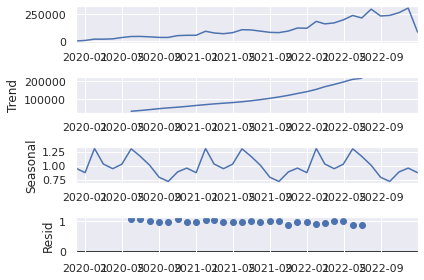

In [668]:
plt.figure(figsize=(30,20))
result_multiplicative = seasonal_decompose(sales_monthly, model ='multiplicative').plot()

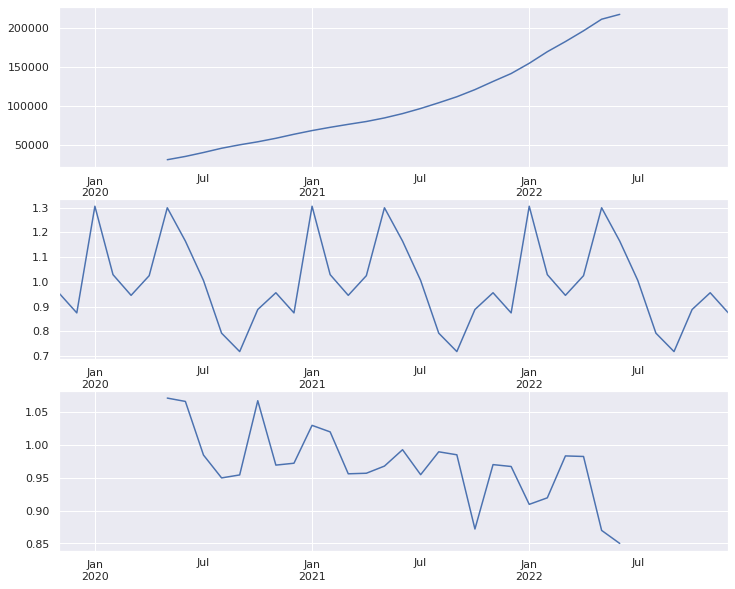

In [669]:
# You can plot a bigger graph by plotting each graph separately. For example,
result_multiplicative = seasonal_decompose(sales_monthly, model ='multiplicative')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,10))
result_multiplicative.trend.plot(ax=ax1)
result_multiplicative.seasonal.plot(ax=ax2)
result_multiplicative.resid.plot(ax=ax3)


## Stationarity

Are the mean, variance and covariance constant over periods or not? As we see above, they are not constant. So, we have non-stationary data. It requires transformation. How can we detect stationarity/non-stationarity?

### 1.Histogram Plot

Plotting a histogram of the time series gives important clues into its underlying structure. A Normal distribution gives confidence that mean and variance are constant. It's certainly not definitive but gives us a good indication.

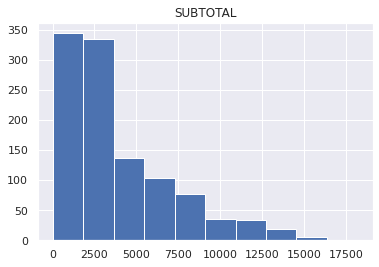

In [670]:
base.hist();

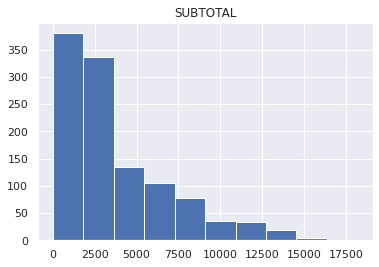

In [671]:
base_new.hist();

### 2. Augmented Dickey-Fuller Test
This is a statistical procedure to suss out whether a time series is stationary or not. Here's what we need to know:
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

Like any statistical test we should set a significance level or threshold that determines whether we should accept or reject the null. 
> The value 0.05 is common but depends upons numerous factors.

Let's see how to run this test in Python.

#### Stationary Data & ADF

In [672]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(base)

In [673]:
print(adf)

-1.2589289344715693


First, **adf** is the value of the test statistic. The more negative the value, the more confident we can be that the series is stationary. Here we see about a value of  -1.26. That may not mean anything to us just yet but the **pvalue** should.

In [674]:
print(pvalue)

0.6477467860471723


Next, **pvalue** is interpreted like any p-value. Once we set a threshold, we can compare this p-value to that threshold. Either we reject or fail to reject the null. Here **pvalue** is about 0.65. So it is not significant and we accept (fail to reject) the null hypothesis that this data is non-stationary.

In [675]:
print(nobs)

1065


The variable **nobs** is simply the number of observations in the time series

In [676]:
print(critical_values)

{'1%': -3.4365050530846846, '5%': -2.864257662806096, '10%': -2.568216983623179}


In [677]:
#### Another way to do Augmented Dickey-Fuller Test

In [678]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(base['SUBTOTAL'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.3
p-value                           0.6
#Lags Used                       21.0
Number of Observations Used   1,065.0
Critical Value (1%)              -3.4
Critical Value (5%)              -2.9
Critical Value (10%)             -2.6
dtype: float64


**Test for stationarity:**
If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

In [679]:
# Let's try for the base_new data frame, which filled nan values with 0 and reindexed.
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(base_new)
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -1.14583222310856
p-value: 0.6964529847661979


### 3.KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

In [680]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

#apply kpss test on the series
kpss_test(base['SUBTOTAL'])  

Results of KPSS Test:
Test Statistic           4.2
p-value                  0.0
Lags Used               22.0
Critical Value (10%)     0.3
Critical Value (5%)      0.5
Critical Value (2.5%)    0.6
Critical Value (1%)      0.7
dtype: float64


**Test for stationarity:** If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). For the air passenger data, the value of the test statistic is greater than the critical value at all confidence intervals, and hence we can say that the series is not stationary.

So in summary, the ADF test has an alternate hypothesis of linear or difference stationary, while the KPSS test identifies trend-stationarity in a series.

### Types of Stationarity
Let us understand the different types of stationarities and how to interpret the results of the above tests.

#### Strict Stationary: 
A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.
#### Trend Stationary: 
A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
#### Difference Stationary: 
A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.

It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

**Case 1:** Both tests conclude that the series is not stationary -> series is not stationary

**Case 2:** Both tests conclude that the series is stationary -> series is stationary

**Case 3:** KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

**Case 4:** KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

### Common Nonstationary-to-Stationary Transformations

In [681]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

#### Differencing
In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. 

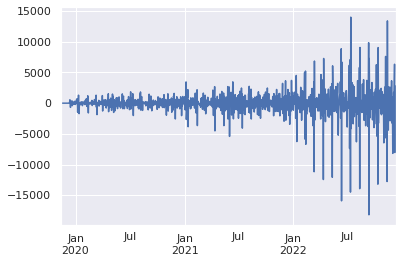

In [682]:
base_new['SUBTOTAL_diff'] = base_new['SUBTOTAL'] - base_new['SUBTOTAL'].shift(1)
base_new['SUBTOTAL_diff'].dropna().plot()

In [683]:
# From another webpage, I saw this code. I may use this df_diff if I need differencing
#df_diff = base_new.diff().diff(12).dropna()

#### Seasonal Differencing
In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday.

In [684]:
"""
n=7
base_new['SUBTOTAL_diff_season'] = base_new['SUBTOTAL'] - base_new['SUBTOTAL'].shift(n)
base_new['SUBTOTAL_diff_season'].dropna().plot()
"""

"\nn=7\nbase_new['SUBTOTAL_diff_season'] = base_new['SUBTOTAL'] - base_new['SUBTOTAL'].shift(n)\nbase_new['SUBTOTAL_diff_season'].dropna().plot()\n"

#### Transformation
Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. Let’s do a quick log transform and differencing on our dataset.

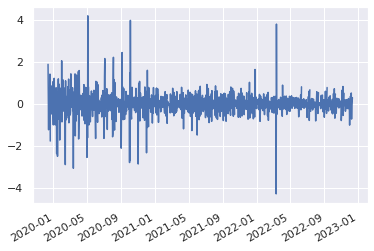

In [685]:
base_new['subtotal_log'] = np.log(base_new['SUBTOTAL'])
base_new['subtotal_log_diff'] = base_new['subtotal_log'] - base_new['subtotal_log'].shift(1)
base_new['subtotal_log_diff'].dropna().plot()

In [686]:
# code from IBM course for just log transformation
"""
#take log of data
base_new['log_sub'] = np.log1p(base_new['SUBTOTAL'])
# going to zoom in on last 60 values to get a better idea of frequency of seasonality
plt.plot(base_new['log_sub'][:60])
plt.xticks(ticks = base_new.iloc[0:60:11].index)
"""

"\n#take log of data\nbase_new['log_sub'] = np.log1p(base_new['SUBTOTAL'])\n# going to zoom in on last 60 values to get a better idea of frequency of seasonality\nplt.plot(base_new['log_sub'][:60])\nplt.xticks(ticks = base_new.iloc[0:60:11].index)\n"

In [687]:
# Define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic            -1.1
p-value                    0.7
Lags Used                 20.0
Observations Used      1,105.0
Critical Value (1%)       -3.4
Critical Value (5%)       -2.9
Critical Value (10%)      -2.6
dtype: float64


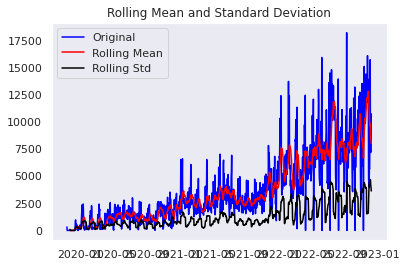

In [688]:
# For SUBTOTAL the test statistic is greater than critical value. So, it is not stationary.

dftest(base_new.SUBTOTAL.dropna())

Test Statistic           -12.5
p-value                    0.0
Lags Used                 19.0
Observations Used      1,105.0
Critical Value (1%)       -3.4
Critical Value (5%)       -2.9
Critical Value (10%)      -2.6
dtype: float64


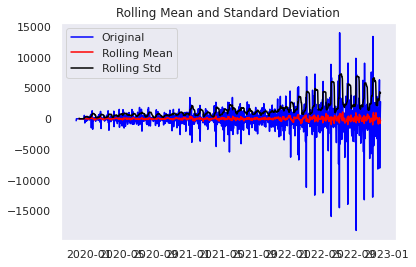

In [689]:
# Let's check SUBTOTAL_diff. Test statistics is lower than critical value. It is stationary.
dftest(base_new.SUBTOTAL_diff.dropna())

In [690]:
base_new.head(10)

,SUBTOTAL,SUBTOTAL_diff,subtotal_log,subtotal_log_diff
2019-11-12,319.4,NaN,5.8,NaN
2019-11-13,0.0,-319.4,-inf,-inf
2019-11-14,0.0,0.0,-inf,NaN
2019-11-15,0.0,0.0,-inf,NaN
2019-11-16,0.0,0.0,-inf,NaN
2019-11-17,0.0,0.0,-inf,NaN
2019-11-18,0.0,0.0,-inf,NaN
2019-11-19,0.0,0.0,-inf,NaN
2019-11-20,0.0,0.0,-inf,NaN
2019-11-21,0.0,0.0,-inf,NaN


# ARIMA, SARIMA & Prophet 

In [691]:
!pip install pmdarima
#conda install -c saravji pmdarima # To install pdarima on Anaconda
from pmdarima import auto_arima
import pmdarima as pm
# pmdarima: a statistical library designed to fill the void in Python's time series analysis capabilities.

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

## SARIMA with Statsmodels

We went through getting stationary data and differencing as that is the last piece of the puzzle that we are missing for understanding ARIMA models. The I stands for "Integrated" which just refers to the amount of differcing done on the data.

When we are determining our ARIMA model we will come across the following standard inputs:
- order(p,d,q):
    - p is number of AR terms
    - d is number of times that we would difference our data
    - q is number of MA terms
    
When we work with SARIMA models 'S' refers to 'seasonal' and we have the additional standard inputs:
- seasonal order(p,d,q):
    - p is number of AR terms in regards to seasonal lag
    - d is number of times that we would difference our seasonal lag (as seen above)
    - q is number of MA terms in regards to seasonal lag
    - s is number of periods in a season

**Types of ARIMA Model**

**ARIMA:** Non-seasonal Autoregressive Integrated Moving Averages

**SARIMA:** Seasonal ARIMA

**SARIMAX:** Seasonal ARIMA with exogenous variables

**Pyramid Auto-ARIMA**

The ‘auto_arima’ function from the ‘pmdarima’ library helps us to identify the most optimal parameters for an ARIMA model and returns a fitted ARIMA model.

**Some rules to highlight from the Duke ARIMA Guide:**
1. If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing
2. If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING!!
3. A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model)

## I. ARIMA MODEL

#### Differentiation

In [692]:
#I will use diff SUBTOTAL instead of SUBTOTAL. Therefore, I will define it as a new data frame named sales_diff

sales_diff = sales_monthly.diff(periods=1) # integrated of order 1 (d parameter in Arima)
sales_diff.head()

,SUBTOTAL
2019-11-30,NaN
2019-12-31,"5,642.5"
2020-01-31,"12,074.9"
2020-02-29,-314.8
2020-03-31,"3,041.3"


In [693]:
sales_diff=sales_diff[1:] # to remove NAN in the first row
sales_diff.head()

,SUBTOTAL
2019-12-31,"5,642.5"
2020-01-31,"12,074.9"
2020-02-29,-314.8
2020-03-31,"3,041.3"
2020-04-30,"12,301.3"


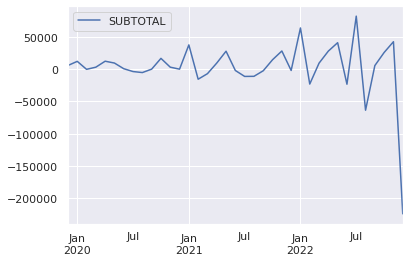

In [694]:
sales_diff.plot() # to check whether it is stationary or not. 
#There is a problem in the last month because of lack of data. Yet, it looks better. 

### Train | Test

In [695]:
# Before splitting our time series let's check the size of our monthly data
SM = sales_monthly.values
SM.size 
# There are 38 months in total in original monthly data


38

In [696]:
X = sales_diff.values
X.size 

37

Since we removed the first month (NaN) in sales_diff, We have just 37 months. Actually, there was not enough data in the first month (November 2019).

Also we can ignore the last month(December 2022) and because we do not have enough data. So there will be 36 months, 27 for train 9 for test.

In [697]:
train = sales_diff.iloc[:len(sales_diff)-10]
test = sales_diff.iloc[len(sales_diff)-10:-1]


print('Train Size',train.size)
print('Test Size',test.size)

Train Size 27
Test Size 9


**Important Note:** In pdmarima v1.5.2, out_of_sample_size is replaced with out_of_sample, so make sure to use the latter!


exogenous -> outside factors (e.g other time series)

m -> seasonal cycle length

max_order -> maximum amount of variables to be used in the regression (p + q)

max_p -> maximum AR components

max_q -> maximum MA components

max_d -> maximum Integrations

maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)

alpha -> level of significance, default is 5%, which we should be using most of the time

n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")

trend -> "ct" usually

information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 

(Akaike Information Criterion, Corrected Akaike Information Criterion,

Bayesian Information Criterion, Hannan-Quinn Information Criterion, or

"out of bag"--for validation scoring--respectively)

out_of_sample (out_of_sample = int(len(df_comp)*0.2)))-> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

In [698]:
# The first function
model_auto = auto_arima(sales_diff, m = 12, max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, 
                        maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob')
                       

model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   37
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -304.716
Date:                            Thu, 26 Jan 2023   AIC                            617.431
Time:                                    23:01:36   BIC                            622.307
Sample:                                12-31-2019   HQIC                           618.784
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.751e+04   8.43e+04      0.208      0.835   -1.48e+05    1.83e+05
drift       -774.5343   2551.402     -0.304      0.761   -5775.191    4226.122
ar.L1         -0.6348      0.773     -0.821      0.411      -2.150       0.880
sigma2      2.329e+09      3.955   5.89e+08      0.000    2.33e+09    2.33e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               160.25
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              32.74   Skew:                            -2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+25. Standard errors may be unstable.
"""

In [699]:
# The second one with different parameters
auto_arima_2 = auto_arima(sales_diff, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
auto_arima_2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=619.499, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=616.985, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=617.675, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=619.530, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=617.308, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=618.465, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=618.828, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=620.417, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=616.132, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=617.915, Time=0.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=619.626, Time=0.14 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=617.267, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=617.931, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=617.582, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   37
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -305.066
Date:                            Thu, 26 Jan 2023   AIC                            614.132
Time:                                    23:01:37   BIC                            616.570
Sample:                                12-31-2019   HQIC                           614.808
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6800      0.598     -1.138      0.255      -1.851       0.491
sigma2       2.42e+09   1.11e-09   2.19e+18      0.000    2.42e+09    2.42e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               205.93
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              37.05   Skew:                            -3.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

We received the same model (1, 0, 0) (0, 1, 0, 12) by using auto arima with different parameters. The first group represents ARIMA (p,i,d), the second one SARIMA.

Nevertheless, I will try (2,0,0) first and (1,0,0) second to compare the models. 

### Fit and Predict the ARIMA model

#### ARIMA (2,0,0)

In [700]:
# For order (2,0,0) (p,i,d)

model_arima_200= ARIMA(sales_diff, order=(2,0,0))
results_arima_200 = model_arima_200.fit()
results_arima_200.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               SUBTOTAL   No. Observations:                   37
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -445.290
Date:                Thu, 26 Jan 2023   AIC                            898.579
Time:                        23:01:37   BIC                            905.023
Sample:                    12-31-2019   HQIC                           900.851
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2233.0847   7296.012      0.306      0.760   -1.21e+04    1.65e+04
ar.L1         -0.7861      0.292     -2.687      0.007      -1.359      -0.213
ar.L2         -0.3474      0.527     -0.660      0.509      -1.380       0.685
sigma2      1.717e+09      0.051   3.39e+10      0.000    1.72e+09    1.72e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               289.95
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):              49.57   Skew:                            -2.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.77e+26. Standard errors may be unstable.
"""

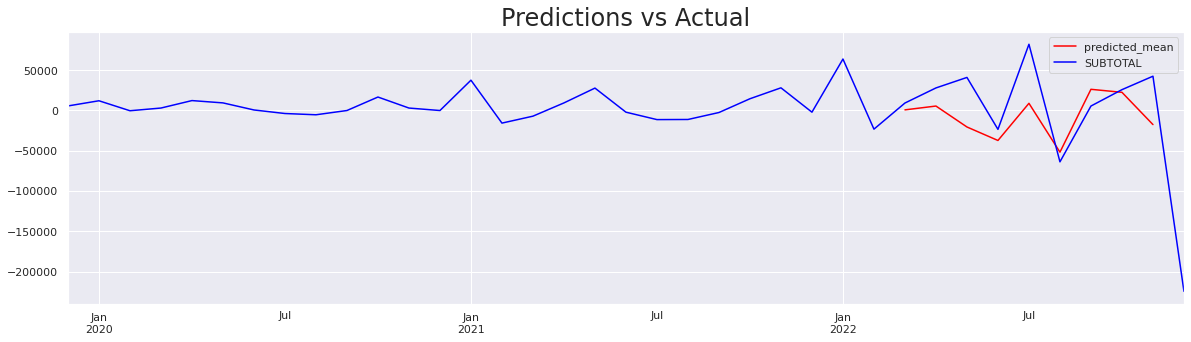

In [701]:
start = len(train)
end = len(train) + len(test) - 1

df_pred_arima_1 = results_arima_200.predict(start, end) 

# plot predictions and actual values
df_pred_arima_1.plot(figsize = (20,5), legend = True, color="red")
sales_diff['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

#### ARIMA (1,0,0)

In [702]:
# order (1,0,0) (p,i,d)

model_arima_100= ARIMA(sales_diff, order=(1,0,0))
results_arima_100 = model_arima_100.fit()
results_arima_100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               SUBTOTAL   No. Observations:                   37
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -446.164
Date:                Thu, 26 Jan 2023   AIC                            898.328
Time:                        23:01:38   BIC                            903.161
Sample:                    12-31-2019   HQIC                           900.032
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2233.0848   5921.090      0.377      0.706   -9372.038    1.38e+04
ar.L1         -0.6365      0.264     -2.406      0.016      -1.155      -0.118
sigma2      1.762e+09      0.044      4e+10      0.000    1.76e+09    1.76e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):               353.88
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):              59.42   Skew:                            -3.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.16e+25. Standard errors may be unstable.
"""

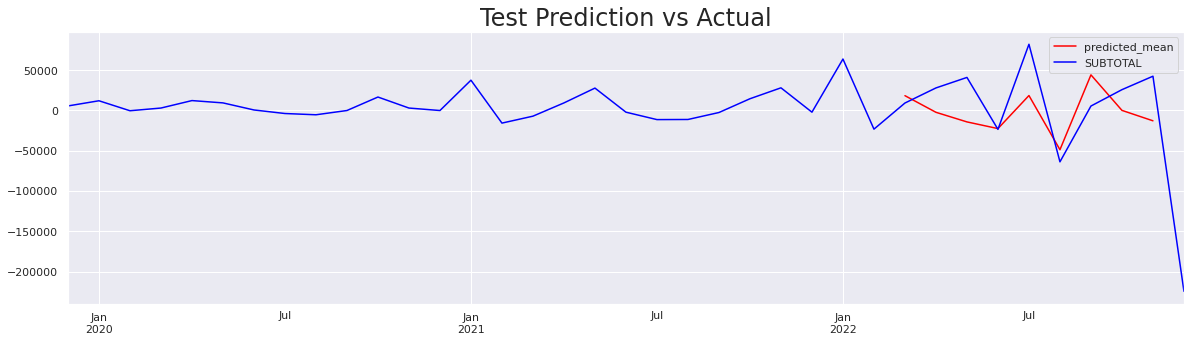

In [703]:
df_pred_arima_2 = results_arima_100.predict(start, end) 

# plot predictions and actual values
df_pred_arima_2.plot(figsize = (20,5), legend = True, color="red")
sales_diff['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Test Prediction vs Actual", size = 24)
plt.show()

#### Evaluate the  ARIMA Models using MSE and RMSE 

In [704]:
### The First Model (2,0,0)
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
    
# Calculate root mean squared error
print('RMSE: ', rmse(test["SUBTOTAL"], df_pred_arima_1))
  
# Calculate mean squared error
print('MSE: ', mean_squared_error(test["SUBTOTAL"], df_pred_arima_1))

RMSE:  39608.97102832403
MSE:  1568870585.9226122


In [705]:
### The Second Model (1,0,0)
print('RMSE: ', rmse(test["SUBTOTAL"], df_pred_arima_2))
  
# Calculate mean squared error
print('MSE: ', mean_squared_error(test["SUBTOTAL"], df_pred_arima_2))

RMSE:  38806.24287671649
MSE:  1505924486.2067091


### Predict the next 6 Months with ARIMA

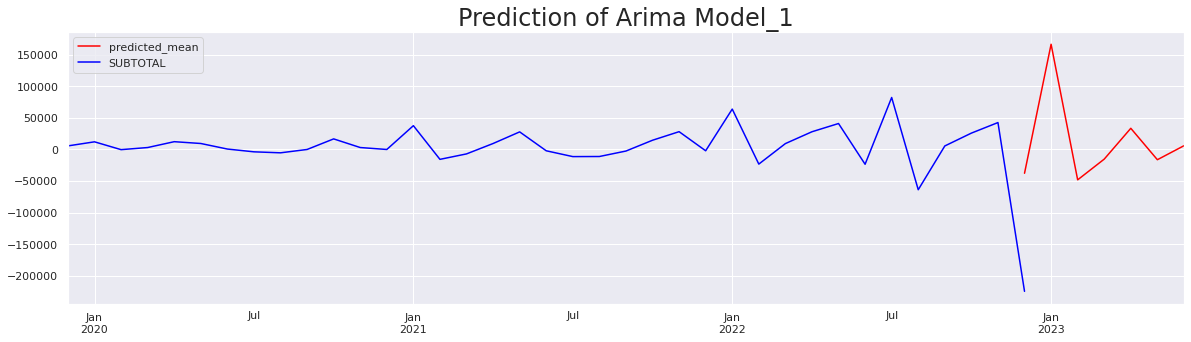

In [706]:
# With the first model

start = len(train) + len(test)
end_date = "2023-06-30"

df_pred_1 = results_arima_200.predict(start, end = end_date)

df_pred_1.plot(figsize = (20,5), legend = True, color="red")
sales_diff['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Prediction of Arima Model_1", size = 24)
plt.show()

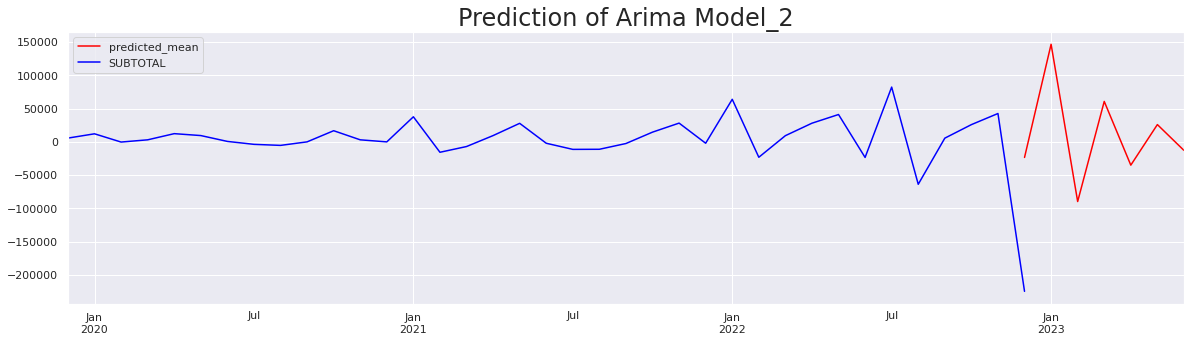

In [707]:
# With the second model
start = len(train) + len(test)
end_date = "2023-06-30"

df_pred_2 = results_arima_100.predict(start, end = end_date)

df_pred_2.plot(figsize = (20,5), legend = True, color="red")
sales_diff['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Prediction of Arima Model_2", size = 24)
plt.show()

## Comparison of both ARIMA Models

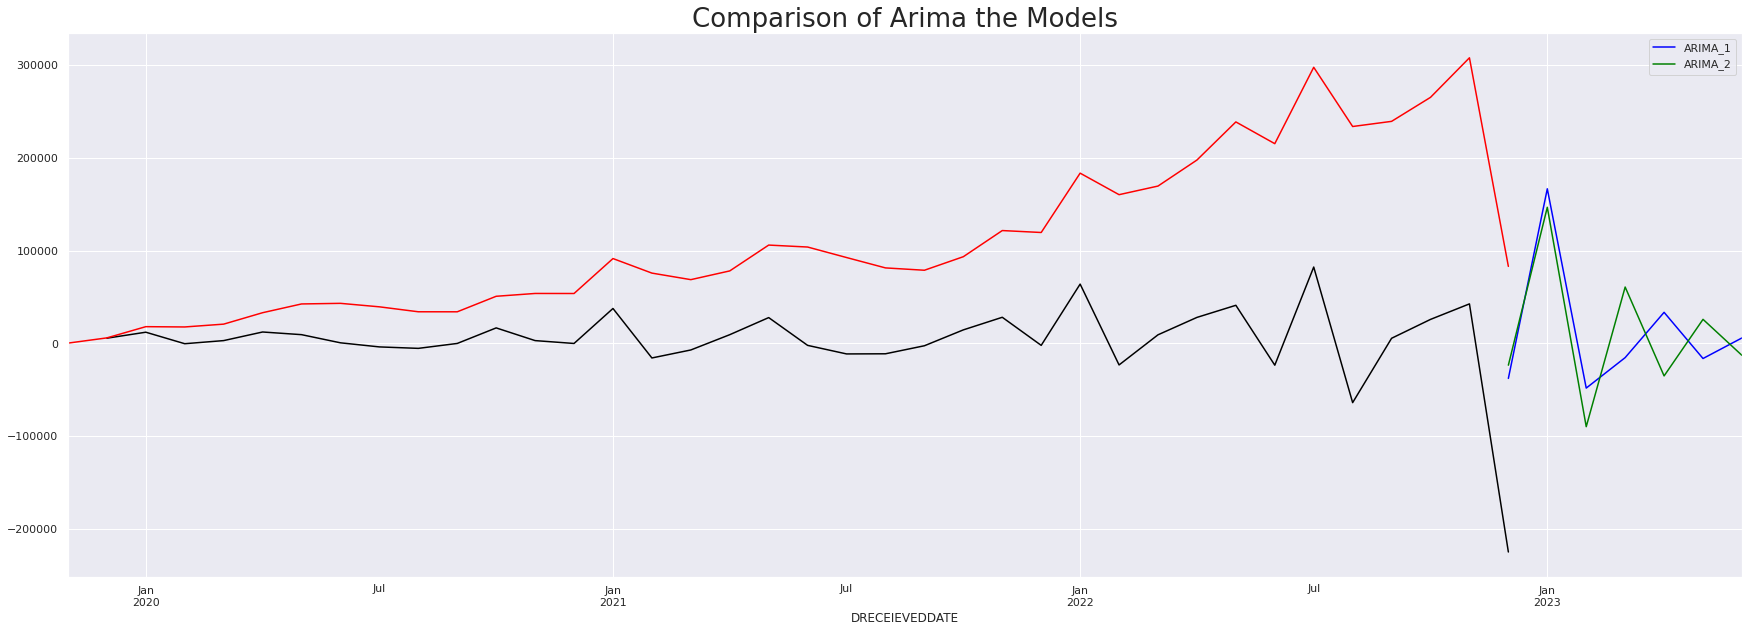

In [708]:
df_pred_1.plot(figsize = (30,10), color = "blue")
df_pred_2.plot(color = "green")
sales_diff['SUBTOTAL'].plot(legend = True, color="black") # stationary data
subtotal_monthly['SUBTOTAL'].plot(legend = True, color="red") # original data with trend and seasonality


plt.legend(['ARIMA_1','ARIMA_2'])
plt.title("Comparison of Arima the Models", size = 26)
plt.show()

## Try with original monthly data

This time I will take "sales_monthly" data instead of "sales_diff". By doing so, I will check whether our models and predictions will chang or not. 

So, the train and test sets are different. For example, the models above was set according to these train and test sets:

train = sales_diff.iloc[:len(sales_diff)-10]

test = sales_diff.iloc[len(sales_diff)-10:-1]

Now, we will try different train and test sets.


In [709]:
train = sales_monthly.iloc[1:len(sales_diff)-9] # November 2019 is not included
test = sales_monthly.iloc[len(sales_diff)-9:-1] # December 2022 is not included

# Check the size of train and test data (months)
print('Train Size',train.size)
print('Test Size',test.size)

Train Size 27
Test Size 9


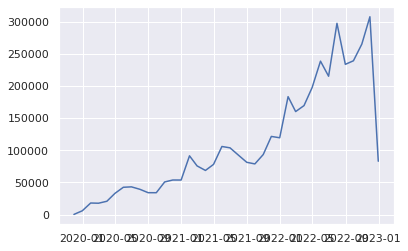

In [710]:
plt.plot(sales_monthly)

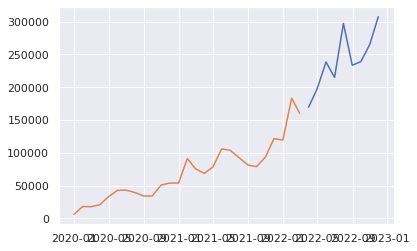

In [711]:
plt.plot(test)
plt.plot(train)

In [712]:
# Let's try auto arima to see whether it will give us a different model or not.
# Here, I used train data and in the next one I will use all the data (sales_monthly).
arima_model_new = auto_arima(train, start_p=0, start_q=0,
                            max_p=5, max_d=5, max_q=5, start_P=0,
                            D=1, start_Q=0, max_P=5, max_D=5,
                            max_Q=5, m=12, seasonal=True,
                            error_action="warn", trace=True,
                            supress_warnings=True, stepwise =True,
                            random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=334.087, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=329.422, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=330.645, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=378.461, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=331.565, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=330.265, Time=0.18 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=330.352, Time=0.11 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=328.764, Time=0.08 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=330.539, Time=0.18 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=332.333, Time=0.34 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=332.448, Time=0.05 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=330.344, Time=0.09 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=329.817, Time=0.10 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=326.596, Time=0.29 sec
 ARIMA(2,0,1)(0,1,0)[12] intercep

To check whether we will have different model if we use all sales data instead of train set.

In [713]:
arima_model_sales = auto_arima(sales_monthly, start_p=0, start_q=0,
                            max_p=5, max_d=5, max_q=5, start_P=0,
                            D=1, start_Q=0, max_P=5, max_D=5,
                            max_Q=5, m=12, seasonal=True,
                            error_action="warn", trace=True,
                            supress_warnings=True, stepwise =True,
                            random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=617.641, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=615.488, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=616.436, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=614.133, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=615.893, Time=0.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=617.424, Time=0.35 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=615.386, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=615.877, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=614.469, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=617.605, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=616.133, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.590 seconds


Yes, we have a different ARIMA model. Which one is better; to use train data or whole data in the model?
I think that for test/train process we should give train data because we consider it as our full data. In this case, the test data will be a kind of prediction. But for future prediction, we can use all the data in the model.

In [714]:
# Let's continue with the train data
arima_model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   27
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -157.298
Date:                            Thu, 26 Jan 2023   AIC                            326.596
Time:                                    23:01:53   BIC                            330.844
Sample:                                12-31-2019   HQIC                           326.551
                                     - 02-28-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.544e+04   6.77e+04      0.671      0.502   -8.72e+04    1.78e+05
ar.L1          0.7453      1.186      0.628      0.530      -1.580       3.070
ar.L2         -0.3973      0.564     -0.705      0.481      -1.502       0.707
ma.L1         -0.5457      0.564     -0.968      0.333      -1.651       0.559
ma.S.L12       0.6306      0.408      1.544      0.123      -0.170       1.431
sigma2      1.225e+08     20.703   5.91e+06      0.000    1.22e+08    1.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.33   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.07   Prob(JB):                         0.70
Heteroskedasticity (H):               3.03   Skew:                            -0.10
Prob(H) (two-sided):                  0.25   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+22. Standard errors may be unstable.
"""

In [715]:
# test prediction in ARIMA (the last 9 months)
 
prediction_arima=pd.DataFrame(arima_model_new.predict(n_periods=20), index=test.index)
prediction_arima.columns = ['predicted_test_sales'] 
prediction_arima

,predicted_test_sales
2022-03-31,"139,282.6"
2022-04-30,"140,500.8"
2022-05-31,"176,361.4"
2022-06-30,"173,589.0"
2022-07-31,"159,804.8"
2022-08-31,"147,949.8"
2022-09-30,"146,376.4"
2022-10-31,"157,436.9"
2022-11-30,"196,341.5"


In [716]:
# original sales (SUBTOTAL) values for comparison 
sales_monthly.tail(10)

,SUBTOTAL
2022-03-31,"169,416.1"
2022-04-30,"197,420.6"
2022-05-31,"238,463.0"
2022-06-30,"215,042.8"
2022-07-31,"297,277.6"
2022-08-31,"233,532.7"
2022-09-30,"239,066.5"
2022-10-31,"264,925.6"
2022-11-30,"307,486.0"
2022-12-31,"82,943.5"


Since the Arima models do not have trend, its predictions are lower than actual sales values (SUBTOTAL).

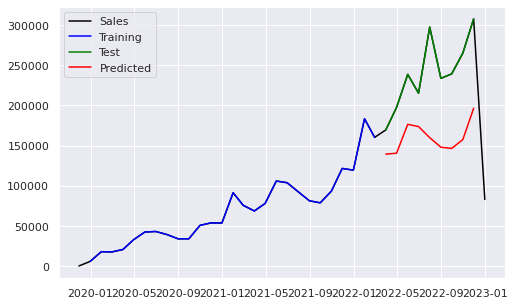

In [717]:
plt.figure(figsize=(8,5))
plt.plot(sales_monthly, label= 'Sales', color="black") # orinal sales and train graphs overlapped.
plt.plot(train, label= 'Training', color="blue") # it seems that there is an overfit in train set.
plt.plot(test, label='Test', color="green")
plt.plot(prediction_arima, label='Predicted', color="red")
plt.legend(loc='upper left');

In [718]:
# R2 score for test data set
from sklearn.metrics import r2_score
test["predicted_sales"]=prediction_arima
r2_score(test['SUBTOTAL'], test["predicted_sales"] )

-3.2996517656275

#### Prediction of Sales in 2023 with ARIMA

Now we can use auto arima model that we had for the all data instead of training data. 
Values in arima_model_sales: ARIMA(1,1,0)(0,1,0)[12] 

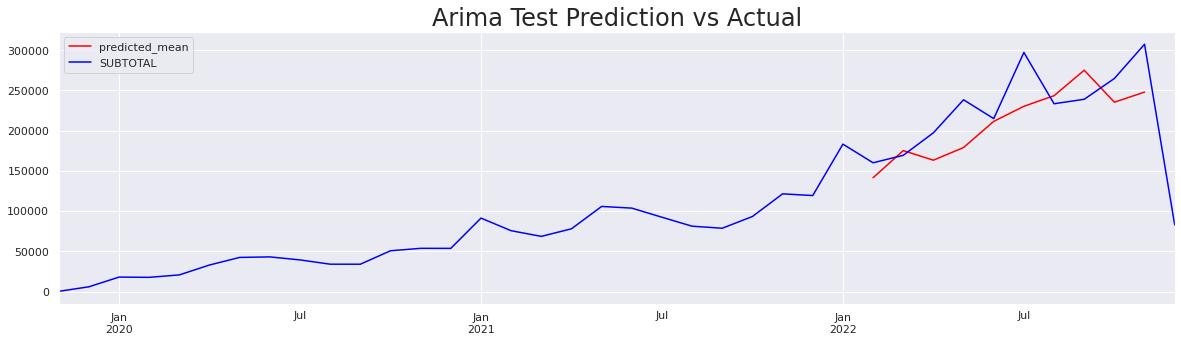

In [719]:
# Test for ARIMA (1,1,0) 

start = len(train)
end_date="2022-11-30"

model_arima_test= ARIMA(sales_monthly, order=(1,1,0))
results_arima_test = model_arima_test.fit()


df_pred_arima_test = results_arima_test.predict(start, end=end_date)

df_pred_arima_test.plot(figsize = (20,5), legend = True, color="red")
sales_monthly['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Arima Test Prediction vs Actual", size = 24);

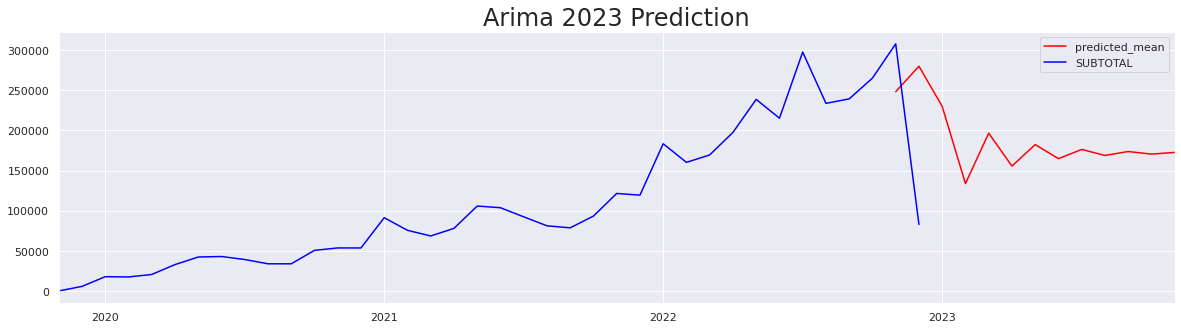

In [720]:
# 2023 Prediction with ARIMA (1,1,0) 

start = len(train) + len(test)
end_date = "2023-11-30"

model_arima_new= ARIMA(sales_monthly, order=(1,1,0))
results_arima_new = model_arima_new.fit()


df_pred_arima_new = results_arima_new.predict(start, end = end_date)

df_pred_arima_new.plot(figsize = (20,5), legend = True, color="red")
sales_monthly['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Arima 2023 Prediction", size = 24);

#### Predicted Sales Vaues with ARIMA: Beginning from November 2022 and until the end of November 2023 

In [721]:
pred_arima_final=pd.DataFrame(df_pred_arima_new)
pred_arima_final.columns = ['arima_predicted_sales'] 
pred_arima_final

,arima_predicted_sales
2022-11-30,"248,023.3"
2022-12-31,"279,667.2"
2023-01-31,"229,711.4"
2023-02-28,"133,779.4"
2023-03-31,"196,483.6"
2023-04-30,"155,498.1"
2023-05-31,"182,287.5"
2023-06-30,"164,777.1"
2023-07-31,"176,222.4"
2023-08-31,"168,741.4"


We can see that Arima Model cannot predict the sales well. Sales values drop in the new year.

# II. SARIMAX MODEL 

In [722]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Prediction of Sales in 2023 with SARIMAX

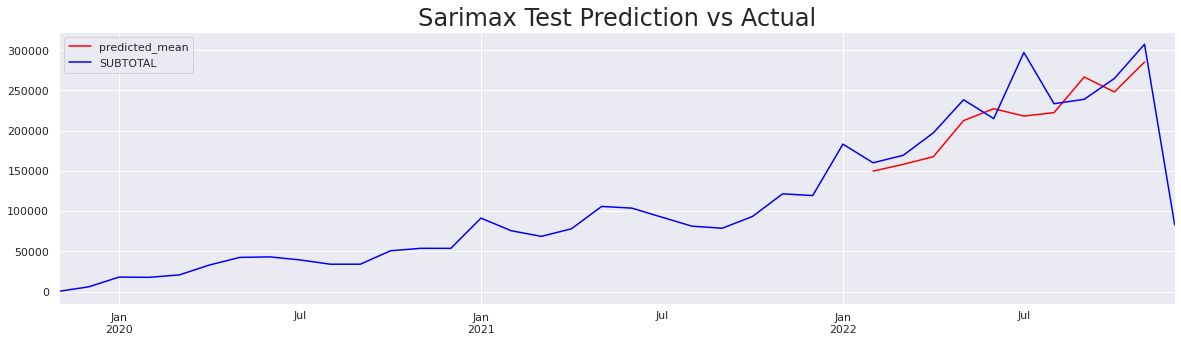

In [723]:
# Test prediction with (1,1,0)(0,1,0)[12] 
start = len(train)
end_date="2022-11-30"

model_sarimax_test = SARIMAX(sales_monthly, order = (1,1,0), seasonal_order = (0,1,0,12))
results_sarimax_test = model_sarimax_test.fit()

df_pred_sarimax_test = results_sarimax_test.predict(start, end = end_date) 

df_pred_sarimax_test.plot(figsize = (20,5), legend = True, color="red")
sales_monthly['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Sarimax Test Prediction vs Actual", size = 24)
plt.show()

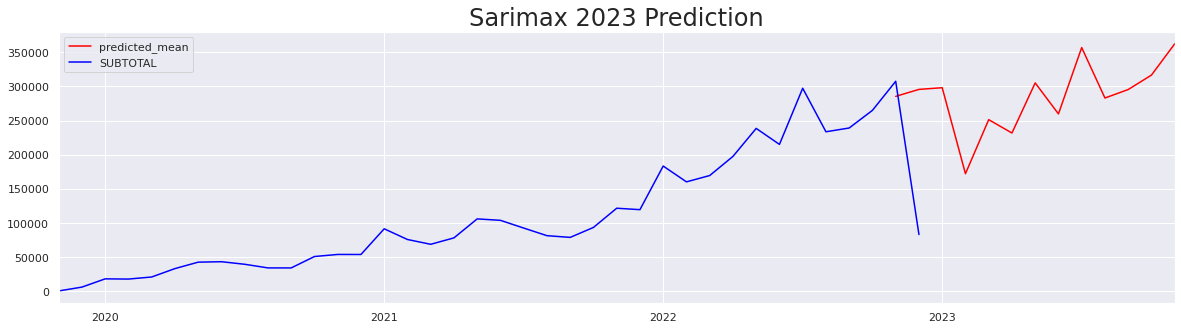

In [724]:
# 2023 Prediction with (1,1,0)(0,1,0)[12] (until the end of November 2023)
start = len(train) + len(test)
end_date = "2023-11-30"

model_sarimax_new = SARIMAX(sales_monthly, order = (1,1,0), seasonal_order = (0,1,0,12))
results_sarimax_new = model_sarimax_new.fit()

df_pred_sarimax_new = results_sarimax_new.predict(start, end = end_date) 

df_pred_sarimax_new.plot(figsize = (20,5), legend = True, color="red")
sales_monthly['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Sarimax 2023 Prediction", size = 24)
plt.show()

#### Predicted Sales Vaues with SARIMAX: Beginning from November 2022 and until the end of November 2023  

In [725]:
pred_sarimax_final=pd.DataFrame(df_pred_sarimax_new)
pred_sarimax_final.columns = ['sarimax_predicted_sales'] 
pred_sarimax_final

,sarimax_predicted_sales
2022-11-30,"285,398.9"
2022-12-31,"295,597.3"
2023-01-31,"298,090.2"
2023-02-28,"172,068.8"
2023-03-31,"251,284.4"
2023-04-30,"231,731.8"
2023-05-31,"305,111.7"
2023-06-30,"259,702.9"
2023-07-31,"356,889.4"
2023-08-31,"282,977.7"


### Let's try once more with new data with 36 months (by removing the first and the last month)

In [726]:
sales_monthly.head(2) # There is no enough data in November 

,SUBTOTAL
2019-11-30,319.4
2019-12-31,"5,961.9"


In [727]:
sales_monthly.tail(2) # December does not have enough data.

,SUBTOTAL
2022-11-30,"307,486.0"
2022-12-31,"82,943.5"


In [728]:
sales_monthly

,SUBTOTAL
2019-11-30,319.4
2019-12-31,"5,961.9"
2020-01-31,"18,036.8"
2020-02-29,"17,722.0"
2020-03-31,"20,763.2"
2020-04-30,"33,064.6"
2020-05-31,"42,497.7"
2020-06-30,"43,149.6"
2020-07-31,"39,395.0"
2020-08-31,"34,071.4"


In [729]:
# drop the first and the last month in the dataset.
sales_36 = sales_monthly.drop(["2019-11-30", "2022-12-31"])


In [730]:
sales_36.head(1) #removed the first and the last rows.

,SUBTOTAL
2019-12-31,"5,961.9"


#### Auto Arima with short data

In [731]:
arima_model_36 = auto_arima(sales_36, start_p=0, start_q=0,
                            max_p=5, max_d=5, max_q=5, start_P=0,
                            D=1, start_Q=0, max_P=5, max_D=5,
                            max_Q=5, m=12, seasonal=True,
                            error_action="warn", trace=True,
                            supress_warnings=True, stepwise =True,
                            random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=535.820, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=532.852, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=534.633, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=531.435, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=533.118, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=534.367, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=533.367, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=533.533, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=533.006, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=533.140, Time=0.65 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=529.976, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=531.921, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=531.958, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=533.915, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12] intercep

In [732]:
train = sales_36.iloc[:len(sales_diff)-10]
test = sales_36.iloc[len(sales_diff)-10:] 


print('Train Size',train.size)
print('Test Size',test.size)

Train Size 27
Test Size 9


#### Test and Prediction With Arima (Short Data)

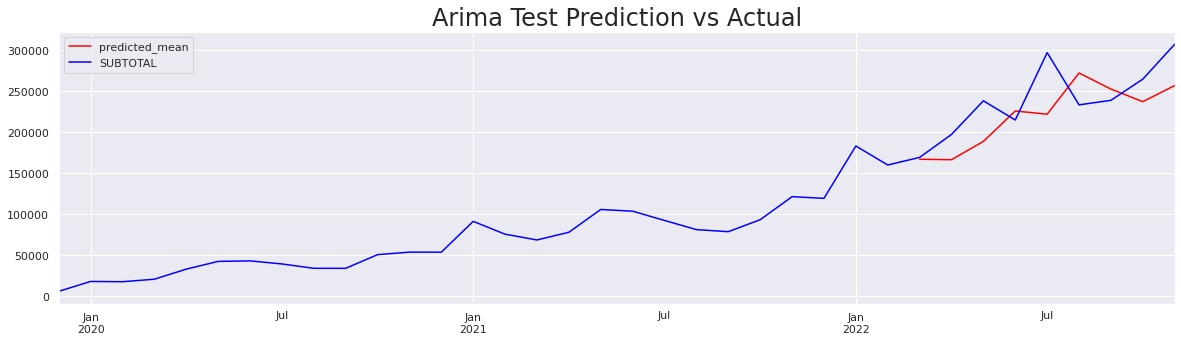

In [603]:
# Test for ARIMA (1,1,0) 

start = len(train)
end_date="2022-11-30"

model_arima_test_36= ARIMA(sales_36, order=(1,1,0))
results_arima_test_36 = model_arima_test_36.fit()


df_pred_arima_test_36 = results_arima_test_36.predict(start, end=end_date)

df_pred_arima_test_36.plot(figsize = (20,5), legend = True, color="red")
sales_36['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Arima Test Prediction vs Actual", size = 24);

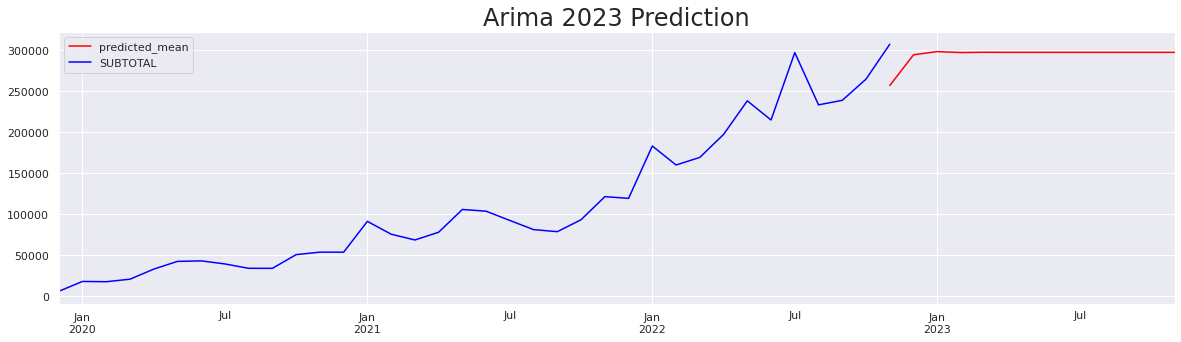

In [604]:
# 2023 Prediction with ARIMA (1,1,0) 

start = len(train) + len(test)-1
end_date = "2023-11-30"

model_arima_pred_36= ARIMA(sales_36, order=(1,1,0))
results_arima_pred_36 = model_arima_pred_36.fit()


df_arima_pred_36 = results_arima_pred_36.predict(start, end = end_date)

df_arima_pred_36.plot(figsize = (20,5), legend = True, color="red")
sales_36['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Arima 2023 Prediction", size = 24);

#### Test and Prediction with SARIMAX (Short Data)

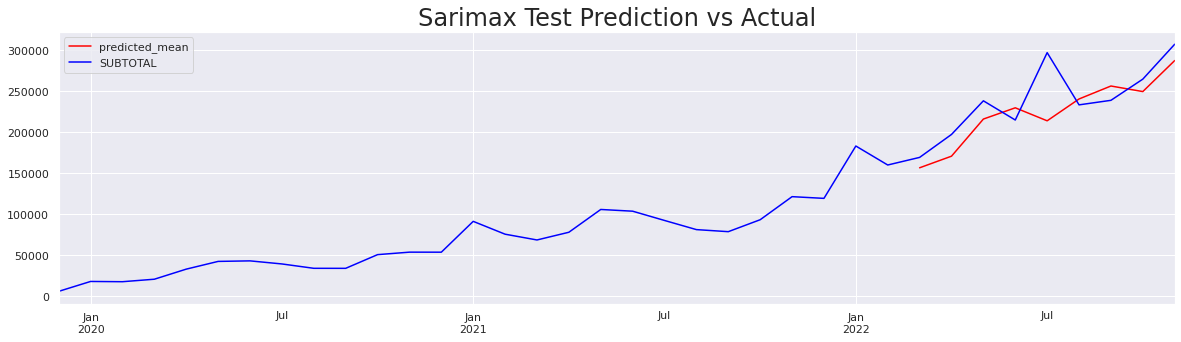

In [605]:
# Test prediction with (1,1,0)(0,1,0)[12]
start = len(train)
end_date="2022-11-30"

model_sarimax_test_36 = SARIMAX(sales_36, order = (1,1,0), seasonal_order = (0,1,0,12))
results_sarimax_test_36 = model_sarimax_test_36.fit()

df_pred_sarimax_test_36 = results_sarimax_test_36.predict(start, end = end_date) 

df_pred_sarimax_test_36.plot(figsize = (20,5), legend = True, color="red")
sales_36['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Sarimax Test Prediction vs Actual", size = 24)
plt.show()

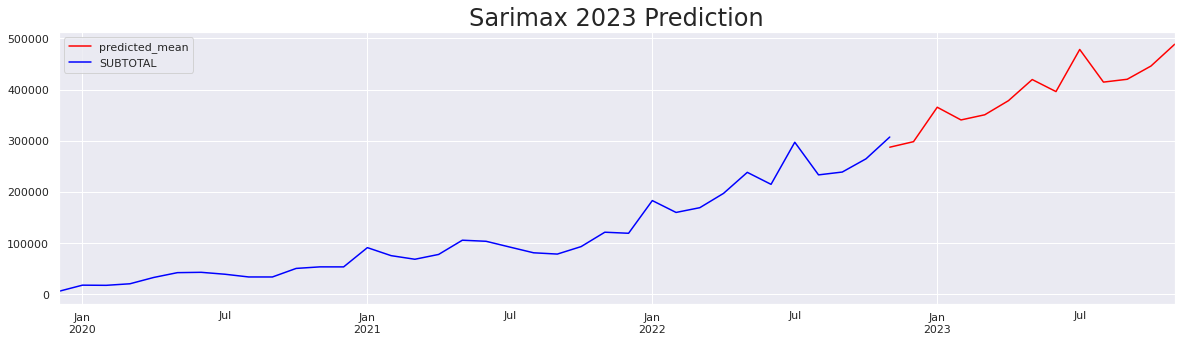

In [606]:
# 2023 Prediction with (1,1,0)(0,1,0)[12] 
start = len(train) + len(test)-1
end_date = "2023-11-30"

model_sarimax_pred_36 = SARIMAX(sales_36, order = (1,1,0), seasonal_order = (0,1,0,12))
results_sarimax_pred_36 = model_sarimax_pred_36.fit()

df_sarimax_pred_36 = results_sarimax_pred_36.predict(start, end = end_date) 

df_sarimax_pred_36.plot(figsize = (20,5), legend = True, color="red")
sales_36['SUBTOTAL'].plot(legend = True, color="blue")
plt.title("Sarimax 2023 Prediction", size = 24)
plt.show()

In [607]:
pred_sarimax_36=pd.DataFrame(df_sarimax_pred_36)
pred_sarimax_36.columns = ['sarimax_predicted_sales'] 
pred_sarimax_36

,sarimax_predicted_sales
2022-11-30,"287,594.6"
2022-12-31,"298,404.7"
2023-01-31,"365,681.2"
2023-02-28,"340,868.6"
2023-03-31,"350,944.2"
2023-04-30,"378,560.7"
2023-05-31,"419,791.3"
2023-06-30,"396,279.8"
2023-07-31,"478,559.0"
2023-08-31,"414,792.5"


In [608]:
# comparison with the former model
pred_sarimax_final

,sarimax_predicted_sales
2022-11-30,"285,398.9"
2022-12-31,"295,597.3"
2023-01-31,"298,090.2"
2023-02-28,"172,068.8"
2023-03-31,"251,284.4"
2023-04-30,"231,731.8"
2023-05-31,"305,111.7"
2023-06-30,"259,702.9"
2023-07-31,"356,889.4"
2023-08-31,"282,977.7"


In [609]:
model_auto_36 = auto_arima(sales_36)

In [610]:
model_auto_36

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

### Compare the models

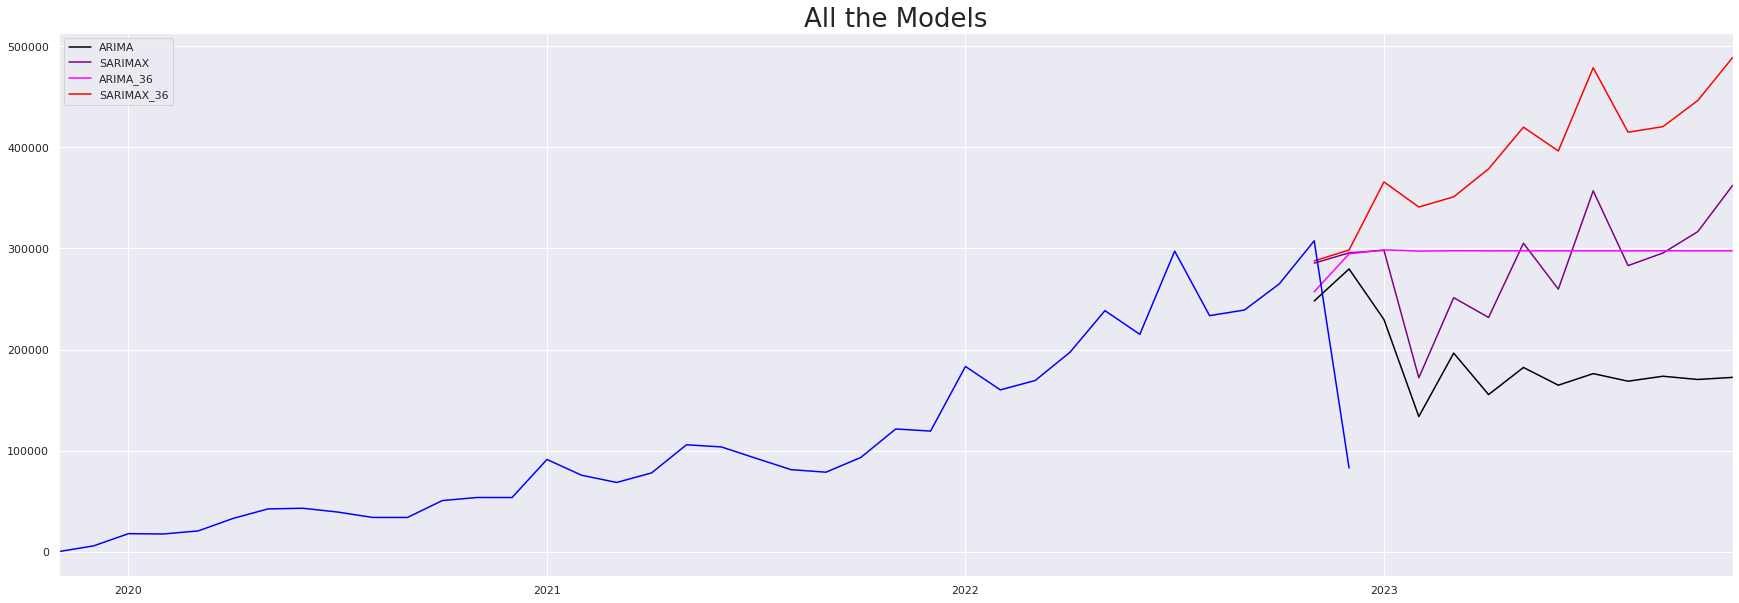

In [611]:
df_pred_arima_new.plot(figsize = (30,10), color = "black") # with sales_monthly data
df_pred_sarimax_new.plot(color = "purple") # with sales_monthly data
df_arima_pred_36.plot(color = "magenta") # with 36 month-data
df_sarimax_pred_36.plot(color ="red" ) # with 36 month-data
sales_monthly['SUBTOTAL'].plot(legend = True, color="blue") # original data


plt.legend(['ARIMA','SARIMAX', 'ARIMA_36', 'SARIMAX_36'])
plt.title("All the Models", size = 26)
plt.show()

According to the graph, we received the best prediction with the SARIMAX model with 36-month data. On the other hand, ARIMA models cannot predict the following term although they worked well in the test data.

# III. Prophet

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: "ds" and "y". The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

Visit: https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [612]:
from prophet import Prophet # Prophet modelling library

## Pre-processing

I will predict Sales (SUBTOTAL) by using Prophet. However, since we do not have a date order in our dataset, first we need to adjust it before applying Prophet. As it is shown below, it does not begin the first date and doe not follow an order until the last date in the dataset.

In [613]:
df1=df_raw[['DRECEIEVEDDATE','SUBTOTAL']]
df1

,DRECEIEVEDDATE,SUBTOTAL
0,2020-03-31,13.9
1,2020-04-24,13.9
2,2020-10-26,77.9
3,2020-06-18,15.9
4,2020-05-04,31.0
...,...,...
94690,2022-10-29,0.0
94691,2022-10-29,0.0
94692,2022-10-29,0.0
94693,2022-10-29,0.0


In [614]:
# Check null values
df1.isnull().sum()

DRECEIEVEDDATE    0
SUBTOTAL          0
dtype: int64

In [615]:
# Check the dtypes. The data type of the date column must be datetime. 
df1.dtypes

DRECEIEVEDDATE    datetime64[ns]
SUBTOTAL                 float64
dtype: object

I will not include November 2019, December 2019 and December 2022 because they do not have enough data. The first two months in the dataset do not have daily sales values. On the other hand, we do not have data for the second half of December 2022. Therefore, their daily sales will be misleading for our prediction.  So, in this model, I will use data beginnig from January 2020 until December 2022.

In [616]:
start_date='2020-01-01'
end_date='2022-11-30'
mask = (df1['DRECEIEVEDDATE'] >= start_date) & (df1['DRECEIEVEDDATE'] <= end_date)

In [617]:
df_daily = df1.loc[mask]

In [618]:
# We do not have an order in terms of date
df_daily.head()

,DRECEIEVEDDATE,SUBTOTAL
0,2020-03-31,13.9
1,2020-04-24,13.9
2,2020-10-26,77.9
3,2020-06-18,15.9
4,2020-05-04,31.0


In [619]:
# Since we have different sales in a day, we need to take daily sums. 
# Also, we need to order our date column
variables = ['DRECEIEVEDDATE', 'SUBTOTAL']
group_variables = variables[0]
outcome_variable = variables[1]
df_daily = df_daily.groupby(group_variables)[outcome_variable].sum().reset_index()

In [620]:
df_daily.index.is_unique

True

In [621]:
# Our date order changed. Now it begins with 01.01.2020 and ends with 30.11.2022
df_daily

,DRECEIEVEDDATE,SUBTOTAL
0,2020-01-01,109.8
1,2020-01-02,209.8
2,2020-01-03,227.5
3,2020-01-04,768.0
4,2020-01-05,"1,311.6"
...,...,...
1052,2022-11-26,"12,421.8"
1053,2022-11-27,"16,071.2"
1054,2022-11-28,"12,841.4"
1055,2022-11-29,"13,902.4"


In [622]:
# the columns must be "ds" and "y"
df_daily.columns = ['ds', 'y']
df_daily.head()

,ds,y
0,2020-01-01,109.8
1,2020-01-02,209.8
2,2020-01-03,227.5
3,2020-01-04,768.0
4,2020-01-05,"1,311.6"


## Create Time Series Model

In [623]:
m = Prophet(interval_width=0.95) 

In [624]:
training_run = m.fit(df_daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41tev4vp/2w9qweez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41tev4vp/gcein4sz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47112', 'data', 'file=/tmp/tmp41tev4vp/2w9qweez.json', 'init=/tmp/tmp41tev4vp/gcein4sz.json', 'output', 'file=/tmp/tmp41tev4vp/prophet_model9hnmb_py/prophet_model-20230126230058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:00:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Evaluate Model

Let's forecast sales values from December to the end of June (212 days)
 
This model also predict from the beginnig so that we can compare predicted values with the actual ones.

In [625]:
 future = m.make_future_dataframe(periods=212, freq='D') 

In [626]:
forecast = m.predict(future)

In [627]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,252.7,"-1,906.5","4,051.5",252.7,252.7,799.3,799.3,799.3,-1.5,-1.5,-1.5,800.8,800.8,800.8,0.0,0.0,0.0,"1,052.1"
1,2020-01-02,257.8,"-2,235.4","3,847.8",257.8,257.8,657.0,657.0,657.0,-225.1,-225.1,-225.1,882.1,882.1,882.1,0.0,0.0,0.0,914.8
2,2020-01-03,262.8,"-1,931.5","3,973.8",262.8,262.8,846.9,846.9,846.9,-103.5,-103.5,-103.5,950.4,950.4,950.4,0.0,0.0,0.0,"1,109.7"
3,2020-01-04,267.8,"-2,120.9","4,145.6",267.8,267.8,862.3,862.3,862.3,-142.7,-142.7,-142.7,"1,005.0","1,005.0","1,005.0",0.0,0.0,0.0,"1,130.2"
4,2020-01-05,272.9,"-1,343.1","4,410.9",272.9,272.9,"1,236.6","1,236.6","1,236.6",191.0,191.0,191.0,"1,045.6","1,045.6","1,045.6",0.0,0.0,0.0,"1,509.5"


In [628]:
forecast_values=forecast[["ds","yhat"]]
forecast_values

,ds,yhat
0,2020-01-01,"1,052.1"
1,2020-01-02,914.8
2,2020-01-03,"1,109.7"
3,2020-01-04,"1,130.2"
4,2020-01-05,"1,509.5"
...,...,...
1264,2023-06-26,"14,631.7"
1265,2023-06-27,"14,572.2"
1266,2023-06-28,"14,560.1"
1267,2023-06-29,"14,404.0"


In [629]:
# Compare the actual sales values below (y) with the predicted sales above (yhat)
df_daily

,ds,y
0,2020-01-01,109.8
1,2020-01-02,209.8
2,2020-01-03,227.5
3,2020-01-04,768.0
4,2020-01-05,"1,311.6"
...,...,...
1052,2022-11-26,"12,421.8"
1053,2022-11-27,"16,071.2"
1054,2022-11-28,"12,841.4"
1055,2022-11-29,"13,902.4"


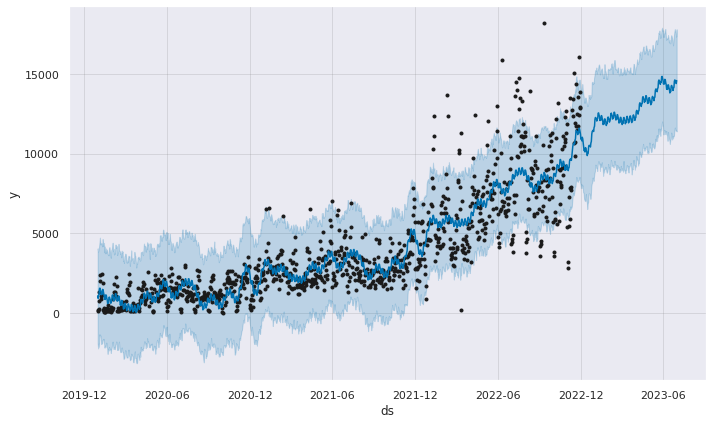

In [630]:
plot1 = m.plot(forecast)

The plot above shows the predictions in the actual term (January 2020-December 2022) as weel as the following term beginning from December 2022 until the end of June (see the trend without values).

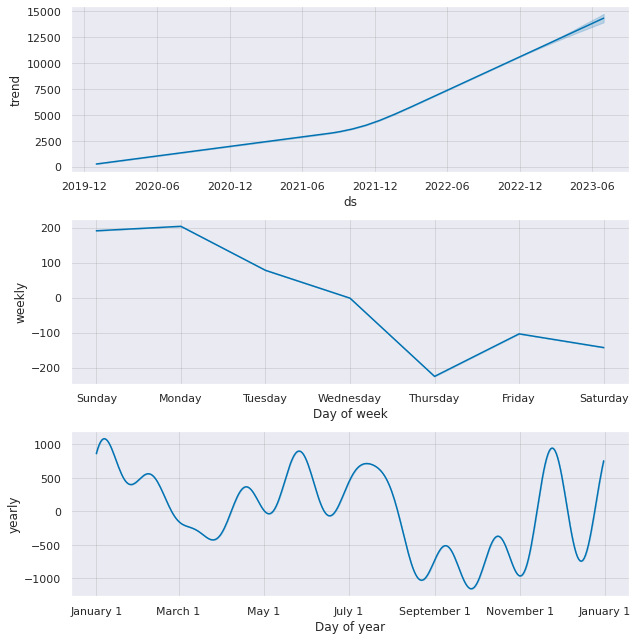

In [631]:
# Let's see its components.
plot2 = m.plot_components(forecast)